# Department of Computer Science

## COS781 Project Proposal

### Clustering Analysis on Sentiment Tagged Parallel Corpus for Luganda and Swahili

**Author**: Arno Jooste (u21457451)  
**Supervisors**: Prof. Vukosi Marivate, Ms. Seani Rananga, Dr. Abiodun Modupe  
**Date**: October 2024  

---

### Introduction

In recent years, research on sentiment analysis has largely neglected African languages. This project addresses this gap by exploring how clustering techniques can be applied to sentiment-tagged corpora in low-resource languages, specifically Luganda and Swahili.

This study investigates:
1. The effectiveness of clustering algorithms specifically KMeans.
2. The impact of feature extraction methods (BoW, or TF-IDF) and topic modeling (LDA).
3. The insights clustering and topic modelling provides into sentiment patterns in Luganda and Swahili texts.

The dataset used is the [Sentiment Tagged Parallel Corpus for Luganda and Swahili](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/XSGIKR), containing thousands of sentences tagged with sentiment labels.

The overall aim is to uncover meaningful relationships between sentiment labels and topics while contributing to the broader field of sentiment analysis for African languages.



# Installments

In [1]:
!pip install wordcloud
!pip install nltk
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/ # run once

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Imports

In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import string
import re
import matplotlib.pyplot as plt
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import requests
import json
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
random_state = 42
np.random.seed(random_state)

# Exploratory Data Analysis

In [4]:
data = pd.read_csv('/kaggle/input/makerere-sentiment-corpus-luganda-and-kiswahil/Makerere_Sentiment_corpus_Luganda_and_Kiswahil_translations.csv')
data_df = pd.DataFrame(data)
data_df

New Sentence  \
0              My friends enjoyed the party last night.   
1     We rejoiced when our uncle who stays in German...   
2     The manager was angry at me when I reached pas...   
3     Last Friday I felt embarrassed when the secret...   
4     She felt disappointed when her father failed t...   
...                                                 ...   
9995  Sadly, the old woman had a hip fracture when s...   
9996  She loves putting on shorts when going to the ...   
9997  My cousin refused to sit for her final examina...   
9998  I was happy when we sat in silence and meditat...   
9999         This is one of my favorite shopping malls.   

                                  Luganda - Translation  \
0     Mikwano gyange gyanyumiddwa akabaga ekiro ekya...   
1     Twajaganya nga kojjaffe abeera e Bugirimaani a...   
2     Maneja yali musunguwavu gyendi bwe natuuka ng'...   
3     Olwokutaano oluwedde nawulira nga nswadde omuw...   
4     Yeewuunya nga kitaawe alemereddwa okugenda ku ...   
...                                                 ...   
9995  Eky'ennaku, omukyala omukadde yanuuse ekisambi...   
9996       Ayagala okwambala ebinu ng'agenda ku bbiici.   
9997  Kizibwe wange yagaanye okutuula ebigezo bya eb...   
9998  Nabadde musanyufu bwe twatudde ne tusiriikirir...   
9999  Kino kye kimu ku bizimbe by'amaduuka bye nsing...   

                                  Swahili - Translation Sentiment code  
0         marafiki wangu walifurahia sherehe jana usiku            Pos  
1     Tulifurahi mjomba wetu anayeishi Ujerumani ali...            Pos  
2     Meneja alinikasirikia nilivyofika zaidi ya saa...            Neg  
3     Ijumaa ilyopita nilijihisi aibu katibu muhtasi...            Neg  
4     Alikosa furaha baba yake aliposhindwa kuhudhur...            Neg  
...                                                 ...            ...  
9995  Inasikitisha, mwanamama huyo mzee alivunjika n...            Neg  
9996         Anapenda kuvaa nguo fupi aendapo ufukweni.            Pos  
9997  Binamu yangu alikataa kufanya mitihani yake ya...            Neg  
9998  Nilifurahi tulipokaa kimya na kutafakari kazi ...            Pos  
9999  Hili ni moja ya maduka makubwa niyapendayo zaidi.            Pos  

[10000 rows x 4 columns]

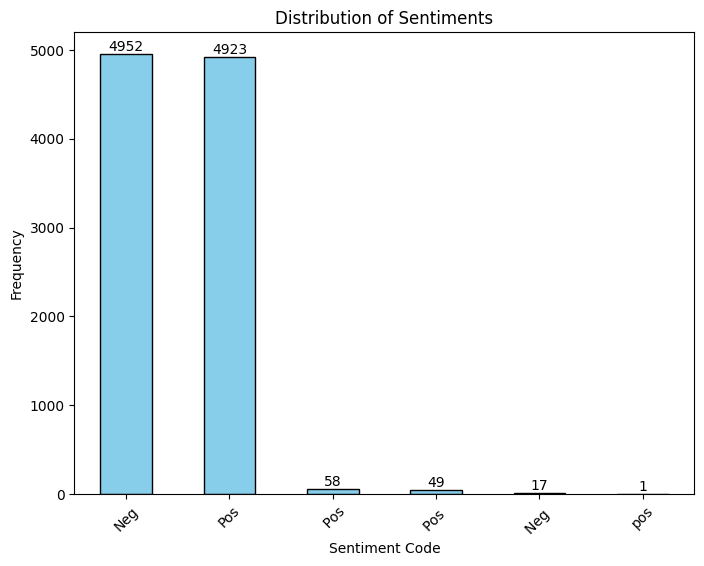

In [5]:
# Visualise distribution of sentiments
plt.figure(figsize=(8, 6))
class_counts = data_df['Sentiment code'].value_counts()
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
# Adding count labels on each bar
for idx, count in enumerate(class_counts):
    plt.text(idx, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

The labels for `Sentiment Code` seems to possibly contain spacing in some instances and in other the spelling differs. Nonetheless, there sems to be an even distribution between the two classes. We will visualise Word Clouds when analysing the topics.

# Data preprocessing

## Renaming columns to simpler names

In [7]:
# Strip any possible whitespace from column names
data_df.columns = data_df.columns.str.strip()

# Renaming columns
data_df.rename(columns={"New Sentence": "English", "Luganda - Translation": "Luganda", "Swahili - Translation": "Swahili", "Sentiment code": "Sentiment"}, inplace=True)
data_df

English  \
0              My friends enjoyed the party last night.   
1     We rejoiced when our uncle who stays in German...   
2     The manager was angry at me when I reached pas...   
3     Last Friday I felt embarrassed when the secret...   
4     She felt disappointed when her father failed t...   
...                                                 ...   
9995  Sadly, the old woman had a hip fracture when s...   
9996  She loves putting on shorts when going to the ...   
9997  My cousin refused to sit for her final examina...   
9998  I was happy when we sat in silence and meditat...   
9999         This is one of my favorite shopping malls.   

                                                Luganda  \
0     Mikwano gyange gyanyumiddwa akabaga ekiro ekya...   
1     Twajaganya nga kojjaffe abeera e Bugirimaani a...   
2     Maneja yali musunguwavu gyendi bwe natuuka ng'...   
3     Olwokutaano oluwedde nawulira nga nswadde omuw...   
4     Yeewuunya nga kitaawe alemereddwa okugenda ku ...   
...                                                 ...   
9995  Eky'ennaku, omukyala omukadde yanuuse ekisambi...   
9996       Ayagala okwambala ebinu ng'agenda ku bbiici.   
9997  Kizibwe wange yagaanye okutuula ebigezo bya eb...   
9998  Nabadde musanyufu bwe twatudde ne tusiriikirir...   
9999  Kino kye kimu ku bizimbe by'amaduuka bye nsing...   

                                                Swahili Sentiment  
0         marafiki wangu walifurahia sherehe jana usiku       Pos  
1     Tulifurahi mjomba wetu anayeishi Ujerumani ali...       Pos  
2     Meneja alinikasirikia nilivyofika zaidi ya saa...       Neg  
3     Ijumaa ilyopita nilijihisi aibu katibu muhtasi...       Neg  
4     Alikosa furaha baba yake aliposhindwa kuhudhur...       Neg  
...                                                 ...       ...  
9995  Inasikitisha, mwanamama huyo mzee alivunjika n...       Neg  
9996         Anapenda kuvaa nguo fupi aendapo ufukweni.       Pos  
9997  Binamu yangu alikataa kufanya mitihani yake ya...       Neg  
9998  Nilifurahi tulipokaa kimya na kutafakari kazi ...       Pos  
9999  Hili ni moja ya maduka makubwa niyapendayo zaidi.       Pos  

[10000 rows x 4 columns]

In [8]:
data_df['Sentiment'].unique()

array(['Pos', 'Neg', ' Pos', 'Neg ', 'Pos ', 'pos'], dtype=object)

## Fix the class labels to be consistent

In [9]:
# Convert to lowercase, remove spaces, and replace values based on the new string
data_df['Sentiment'] = data_df['Sentiment'].str.lower().str.strip().replace({'pos': 'Pos', 'neg': 'Neg'})
print(data_df['Sentiment'].unique())

['Pos' 'Neg']


## Analyse the missing values

In [10]:
data_df.isnull().sum()

English      0
Luganda      0
Swahili      3
Sentiment    0
dtype: int64

### Remove the 3 missing Swahili values

In [11]:
data_df.dropna(inplace=True)
data_df.isnull().sum()

English      0
Luganda      0
Swahili      0
Sentiment    0
dtype: int64

# Install and use packages to get the stop words of each language

We cannot make use of the `stopwords` package to get the stop words for Luganda or Swahili. Thus, we will make use of other researchers' compiled lists for Luganda and Swahili.

**Source for getting Luganda stop words:** [mukairnlpv1](https://pypi.org/project/mukairnlpv1/#description)

**Source for getting Swahili stop words:** [more-stoplists](https://github.com/dohliam/more-stoplists/tree/master)

In [12]:
# Install necessary package for Luganda stop words
!pip install mukairnlpv1

In [13]:
from mukairnlpv1 import stop_words

luganda_stop_words = list(stop_words.STOP_WORDS)
print(luganda_stop_words)

['bali', 'ffe', 'mingi', 'neetaaga', 'nnyingi', 'babadde', 'oli', 'waggulunnina', 'nnyo', 'nandiyagadde', 'kye', 'yonna', 'leero', "n'olwekyo", 'teyalina', 'tetulina', 'nabo', 'balina', 'kiki', 'bibye', 'bebombi', 'ekyo', 'ddi', 'bwaffe', 'zijja', 'bino', 'kubangabyombi', 'bwayo', 'bwe', 'okutuusa', 'byonna', 'wano', 'bulungi', 'kino', 'wandi', 'si', 'bimu', 'ku', 'byabwe', 'kudda', 'abava', 'yabadde', 'endala', 'tebayina', 'ebimu', 'ddaa', 'ennyo', 'nnyini', 'munda', 'kikyo', 'bwonna', 'kuva', 'byebimu', 'nandiye', 'wadde', 'bajjanewankubade', 'bajja', 'nedda', 'bingi', 'liryo', 'lyaffe', 'okuggyako', 'guno', 'edda', 'buli', 'mwegyabwe', 'lwa', 'nnyinza', 'bo', 'yennyini', 'erina', 'kyekimuoyo', 'bya', 'tuyina', 'tebaali', 'ono', 'beera', 'ebyo', 'ejja', 'lwaki', 'baweebwa', 'okuwa', 'talina', 'tayina', 'ekirala', 'ffenna', 'wa', 'bonna', 'nti', 'tolina', 'ojja', 'byaffe', 'ani', 'bateekeddwa', 'kikye', 'yaffe', 'engeri', 'okugenda', 'atya', 'naye', 'oluvannyuma', 'ateekeddwa', 'mu', 

In [14]:
# The swahili stop words will be downloaded using their source urls
urls = {
    "corpus_stats": "https://raw.githubusercontent.com/dohliam/more-stoplists/master/sw/corpus_stats-sw.md",
    "sw_frequency_list": "https://raw.githubusercontent.com/dohliam/more-stoplists/master/sw/sw_frequency_list.txt",
    "sw_json": "https://raw.githubusercontent.com/dohliam/more-stoplists/master/sw/sw.json",
    "sw_txt": "https://raw.githubusercontent.com/dohliam/more-stoplists/master/sw/sw.txt"
}

# Download and read the files into variables
sw_data = {}
for name, url in urls.items():
    response = requests.get(url)
    if response.status_code == 200:
        if name == "sw_json":
            sw_data[name] = json.loads(response.text)  # Read JSON as a list
        else:
            sw_data[name] = response.text.splitlines()  # Read as a list of lines
    else:
        print(f"Failed to download {name}.")

# We can verify if both the json and txt file contained the same values
print("Swahili Stop words (from sw.txt):", sorted(sw_data["sw_txt"]))
print("Stop words (from sw.json):", sw_data["sw_json"])

# Initialise the swahili stop words
swahili_stop_words = sw_data["sw_json"]

Swahili Stop words (from sw.txt): ['akasema', 'alikuwa', 'alisema', 'baada', 'basi', 'bila', 'cha', 'chini', 'hadi', 'hapo', 'hata', 'hivyo', 'hiyo', 'huku', 'huo', 'ili', 'ilikuwa', 'juu', 'kama', 'karibu', 'katika', 'kila', 'kima', 'kisha', 'kubwa', 'kutoka', 'kuwa', 'kwa', 'kwamba', 'kwenda', 'kwenye', 'la', 'lakini', 'mara', 'mdogo', 'mimi', 'mkubwa', 'mmoja', 'moja', 'muda', 'mwenye', 'na', 'naye', 'ndani', 'ng', 'ni', 'nini', 'nonkungu', 'pamoja', 'pia', 'sana', 'sasa', 'sauti', 'tafadhali', 'tena', 'tu', 'vile', 'wa', 'wakati', 'wake', 'walikuwa', 'wao', 'watu', 'wengine', 'wote', 'ya', 'yake', 'yangu', 'yao', 'yeye', 'yule', 'za', 'zaidi', 'zake']
Stop words (from sw.json): ['akasema', 'alikuwa', 'alisema', 'baada', 'basi', 'bila', 'cha', 'chini', 'hadi', 'hapo', 'hata', 'hivyo', 'hiyo', 'huku', 'huo', 'ili', 'ilikuwa', 'juu', 'kama', 'karibu', 'katika', 'kila', 'kima', 'kisha', 'kubwa', 'kutoka', 'kuwa', 'kwa', 'kwamba', 'kwenda', 'kwenye', 'la', 'lakini', 'mara', 'mdogo', 'mi

In [15]:
for i, sentence in enumerate(data_df["Swahili"]):
    if "mtoto" in sentence:
        print(f"Sentence {i}: {sentence}")
        print(f"English index: {data_df['English'].iloc[i]}")
        break

Sentence 34: Alipata maoni mabaya kuhusiana na tabia ya mtoto wake wa kiume shuleni
English index: He received bad comments about his son's behavior in school.


In [16]:
# Get english stopwords
from nltk.corpus import stopwords
english_stop_words = set(stopwords.words('english'))

## Remove stop words and lemmatize the sentences

In [17]:
# Initialise the lemmatiser and stop words
lemmatiser = WordNetLemmatizer()

def preprocess_text(text, language='luganda', stop_words=None):
    """
    Preprocesses a given text by performing several steps including case normalisation, tokenization, punctuation removal, stop word filtering, and lemmatization.
    
    - Steps:
        1. Converts the input text to lowercase.
        2. Removes non-ASCII characters from the text.
        3. Tokenizes the text into words.
        4. Removes punctuation tokens.
        5. Filters out any stop words.
        6. Applies lemmatization to each remaining token.

    - Notes:
        - Requires `nltk` for tokenization and lemmatization.
        - Ensure `stop_words` is provided to prevent an error.

    Args:
        text (str): The input text to be processed.
        language (str, optional): The language of the input text. Default is 'luganda'.
        stop_words (set or list, optional): A collection of stop words specific to the given language. Must not be None.

    Raises:
        ValueError: If `stop_words` is None.

    Returns:
        str: The preprocessed text as a single string, with tokens joined by spaces.
    """
    if stop_words is None:
        raise ValueError("The variable stop_words should not be 'None'. Ensure the correct stop words are passed in.")
    
    # Convert to lowercase
    try:
        text = text.lower()
    except:
        print(f"Error processing text: {text}")
        
    # Remove any non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    
    # Tokenise
    tokens = nltk.word_tokenize(text)
    
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    
    # Apply lemmatisation
    tokens = [lemmatiser.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

# Apply preprocessing
data_df['English'] = data_df['English'].apply(lambda x: preprocess_text(x, 'english', english_stop_words))
data_df['Luganda'] = data_df['Luganda'].apply(lambda x: preprocess_text(x, 'luganda', luganda_stop_words))
data_df['Swahili'] = data_df['Swahili'].apply(lambda x: preprocess_text(x, 'swahili', swahili_stop_words))

print(data_df[['English', 'Luganda', 'Swahili']].head())

                                             English  \
0                    friend enjoyed party last night   
1         rejoiced uncle stay germany invited u join   
2           manager angry reached past eight morning   
3  last friday felt embarrassed secretary disresp...   
4  felt disappointed father failed attend graduat...   

                                             Luganda  \
0  mikwano gyange gyanyumiddwa akabaga ekiro ekya...   
1  twajaganya kojjaffe abeera bugirimaani atuyise...   
2  maneja yali musunguwavu gyendi natuuka ng'obud...   
3  olwokutaano oluwedde nawulira nswadde omuwandi...   
4         yeewuunya kitaawe alemereddwa matikkira ge   

                                             Swahili  
0      marafiki wangu walifurahia sherehe jana usiku  
1  tulifurahi mjomba wetu anayeishi ujerumani ali...  
2  meneja alinikasirikia nilivyofika saa mbili as...  
3  ijumaa ilyopita nilijihisi aibu katibu muhtasi...  
4  alikosa furaha baba aliposhindwa kuhudhuria ma..

## Encode class labels
For the encoding we will encode the `Pos` class label as `1` and the `Neg` label as `0`.

In [18]:
# Map sentiment labels to binary values
data_df['Sentiment Encoded'] = data_df['Sentiment'].map({'Pos': 1, 'Neg': 0})
data_df.head()

English  \
0                    friend enjoyed party last night   
1         rejoiced uncle stay germany invited u join   
2           manager angry reached past eight morning   
3  last friday felt embarrassed secretary disresp...   
4  felt disappointed father failed attend graduat...   

                                             Luganda  \
0  mikwano gyange gyanyumiddwa akabaga ekiro ekya...   
1  twajaganya kojjaffe abeera bugirimaani atuyise...   
2  maneja yali musunguwavu gyendi natuuka ng'obud...   
3  olwokutaano oluwedde nawulira nswadde omuwandi...   
4         yeewuunya kitaawe alemereddwa matikkira ge   

                                             Swahili Sentiment  \
0      marafiki wangu walifurahia sherehe jana usiku       Pos   
1  tulifurahi mjomba wetu anayeishi ujerumani ali...       Pos   
2  meneja alinikasirikia nilivyofika saa mbili as...       Neg   
3  ijumaa ilyopita nilijihisi aibu katibu muhtasi...       Neg   
4  alikosa furaha baba aliposhindwa kuhudhuria ma...       Neg   

   Sentiment Encoded  
0                  1  
1                  1  
2                  0  
3                  0  
4                  0

## Now we do feature extraction using Bag-of-Words (BoW) and TF-IDF

In [19]:
from scipy.sparse import hstack

# Set max features
max_features = 5000

# Initialise BoW and TF-IDF Vectorizers
english_vectorizer_bow = CountVectorizer(max_features=max_features)
luganda_vectorizer_bow = CountVectorizer(max_features=max_features)
swahili_vectorizer_bow = CountVectorizer(max_features=max_features)

english_vectorizer_tfidf = TfidfVectorizer(max_features=max_features)
luganda_vectorizer_tfidf = TfidfVectorizer(max_features=max_features)
swahili_vectorizer_tfidf = TfidfVectorizer(max_features=max_features)

# Fit and transform Luganda and Swahili sentences with BoW
english_bow = english_vectorizer_bow.fit_transform(data_df['English'])
luganda_bow = luganda_vectorizer_bow.fit_transform(data_df['Luganda'])
swahili_bow = swahili_vectorizer_bow.fit_transform(data_df['Swahili'])

# Fit and transform Luganda and Swahili sentences with TF-IDF
english_tfidf = english_vectorizer_tfidf.fit_transform(data_df['English'])
luganda_tfidf = luganda_vectorizer_tfidf.fit_transform(data_df['Luganda'])
swahili_tfidf = swahili_vectorizer_tfidf.fit_transform(data_df['Swahili'])

# Combine BoW and TF-IDF features for English, Luganda, and Swahili
combined_features = hstack([english_bow, luganda_bow, swahili_bow, english_tfidf, luganda_tfidf, swahili_tfidf])

# Print combined feature matrix shape
print(f"Combined Feature Matrix Shape (BoW + TF-IDF): {combined_features.shape}")


Combined Feature Matrix Shape (BoW + TF-IDF): (9997, 29242)


In [20]:
# within_cluster = fit_clusters(combined_features, x_range, repetitions) # Using combined TF-IDF + BoW

# Pipeline: TF-IDF, KMeans, LDA

In [21]:
from sklearn.cluster import KMeans, MiniBatchKMeans

def train_kmeans(X, k):
    """
    Trains a KMeans clustering model using MiniBatchKMeans.
    
    - Notes:
        - The function uses a batch size of 2048 and initialises the model with 3 random starts (n_init=3) to find the optimal clustering arrangement.
        - MiniBatchKMeans is preferred for large datasets as it uses mini-batches, making it faster than the standard KMeans implementation.

    Args:
        X (numpy.ndarray): The input data for clustering, with each row representing a data point and each column a feature.
        k (int): The number of clusters to form.

    Returns:
        clf (MiniBatchKMeans): The trained MiniBatchKMeans model.
        within_cluster (float): The within-cluster sum of squares, representing the model's inertia or the measure of compactness for each cluster.
    """
    clf = MiniBatchKMeans(n_clusters=k, batch_size=2048, n_init=3)
    clf.fit(X)
    within_cluster = clf.inertia_

    return clf, within_cluster

In [22]:
repetitions = 5
x_range = range(20,421,20)

english_within_cluster = []
luganda_within_cluster = []
swahili_within_cluster = []

def fit_clusters(X, within_cluster, x_range, repetitions):
    """
    Fits KMeans clustering models for a range of cluster counts and records the within-cluster sum of squares.
    
    - Notes:
        - This function calls `train_kmeans` to fit the clustering model and obtain the within-cluster sum of squares.
        - For each `k` in `x_range`, the clustering process is repeated `repetitions` times, and the resulting within-cluster sum of squares values are stored in `within_cluster`.
        - The function is useful for evaluating clustering performance across different numbers of clusters, which can assist in identifying the optimal number of clusters based on inertia.

    Args:
        X (numpy.ndarray): The dataset for clustering, with each row representing a data point and each column a feature.
        within_cluster (list): A list to store the within-cluster sum of squares (inertia) for each value of `k` in `x_range`.
        x_range (iterable): An iterable of integers, where each integer represents a number of clusters to try.
        repetitions (int): The number of times to repeat the clustering process for each value of `k` in `x_range`.

    Returns:
        numpy.ndarray: A 2D array where each row corresponds to a value of `k` in `x_range`, and each column contains a within-cluster sum of squares value for a single repetition.
    """
    for k in x_range:
        temp_wc = []
        print('Fit {} clusters'.format(k))
        for i in range(repetitions):
            _, within_cluster_single = train_kmeans(X, k)
            temp_wc.append(within_cluster_single)
        within_cluster.append(temp_wc)
    return np.array(within_cluster)

print('Fitting cluters for English')
english_within_cluster = fit_clusters(english_tfidf, english_within_cluster, x_range, repetitions)

print('Fitting cluters for Luganda')
luganda_within_cluster = fit_clusters(luganda_tfidf, luganda_within_cluster, x_range, repetitions)

print('Fitting cluters for Swahili')
swahili_within_cluster = fit_clusters(swahili_tfidf, swahili_within_cluster, x_range, repetitions)

Fitting cluters for English
Fit 20 clusters
Fit 40 clusters
Fit 60 clusters
Fit 80 clusters
Fit 100 clusters
Fit 120 clusters
Fit 140 clusters
Fit 160 clusters
Fit 180 clusters
Fit 200 clusters
Fit 220 clusters
Fit 240 clusters
Fit 260 clusters
Fit 280 clusters
Fit 300 clusters
Fit 320 clusters
Fit 340 clusters
Fit 360 clusters
Fit 380 clusters
Fit 400 clusters
Fit 420 clusters
Fitting cluters for Luganda
Fit 20 clusters
Fit 40 clusters
Fit 60 clusters
Fit 80 clusters
Fit 100 clusters
Fit 120 clusters
Fit 140 clusters
Fit 160 clusters
Fit 180 clusters
Fit 200 clusters
Fit 220 clusters
Fit 240 clusters
Fit 260 clusters
Fit 280 clusters
Fit 300 clusters
Fit 320 clusters
Fit 340 clusters
Fit 360 clusters
Fit 380 clusters
Fit 400 clusters
Fit 420 clusters
Fitting cluters for Swahili
Fit 20 clusters
Fit 40 clusters
Fit 60 clusters
Fit 80 clusters
Fit 100 clusters
Fit 120 clusters
Fit 140 clusters
Fit 160 clusters
Fit 180 clusters
Fit 200 clusters
Fit 220 clusters
Fit 240 clusters
Fit 260 cl

In [23]:
import plotly.express as px

def plot_elbow_graph(within_cluster, language='English'):
    """
    Plots an elbow graph to visualise the within-cluster sum of squares (inertia) across different numbers of clusters for KMeans clustering.

    - Notes:
        - This function calculates the average within-cluster sum of squares for each cluster count, using the `within_cluster` array.
        - It generates an interactive line plot with markers, showing the number of clusters on the x-axis and inertia on the y-axis.
        - The elbow method helps in determining the optimal number of clusters by identifying the point where inertia reduction slows.
        
    Args:
        within_cluster (numpy.ndarray): A 2D array where each row represents the within-cluster sum of squares for a specific number of clusters, and each column corresponds to a repetition.
        language (str): The language label for the plot title, indicating the dataset or language being analysed (default is 'English').

    Returns:
        None: Displays an interactive elbow graph showing the relationship between the number of clusters and inertia.
    """
    avg_within_cluster = np.mean(within_cluster,axis=1)
    
    df = pd.DataFrame({'Number of clusters': x_range, 'Inertia': avg_within_cluster})

    fig = px.line(df, x='Number of clusters', y='Inertia', markers=True, 
                  title=f'{language}: Number of clusters vs. Inertia',
                  labels={'Inertia': 'Inertia (Sum of Square Errors)'})
    fig.show()

In [24]:
plot_elbow_graph(english_within_cluster, language='English')

In [25]:
plot_elbow_graph(luganda_within_cluster, language='Luganda')

In [26]:
plot_elbow_graph(swahili_within_cluster, language='Swahili')

In [27]:
english_k = 100
luganda_k = 60
swahili_k = 80

english_clf, english_wc = train_kmeans(english_tfidf, english_k)
english_cluster_labels = english_clf.predict(english_tfidf)

luganda_clf, luganda_wc = train_kmeans(luganda_tfidf, luganda_k)
luganda_cluster_labels = luganda_clf.predict(luganda_tfidf)

swahili_clf, swahili_wc = train_kmeans(swahili_tfidf, swahili_k)
swahili_cluster_labels = swahili_clf.predict(swahili_tfidf)

In [28]:
np.random.seed(seed=random_state)

english_random_sample = np.random.choice(range(english_tfidf.shape[0]), size=2000, replace=False)
english_tfidf_sample = english_tfidf[english_random_sample,:]
english_cluster_labels_sample = english_cluster_labels[english_random_sample]

luganda_random_sample = np.random.choice(range(luganda_tfidf.shape[0]), size=2000, replace=False)
luganda_tfidf_sample = luganda_tfidf[luganda_random_sample,:]
luganda_cluster_labels_sample = luganda_cluster_labels[luganda_random_sample]

swahili_random_sample = np.random.choice(range(swahili_tfidf.shape[0]), size=2000, replace=False)
swahili_tfidf_sample = swahili_tfidf[swahili_random_sample,:]
swahili_cluster_labels_sample = swahili_cluster_labels[swahili_random_sample]

In [29]:
english_df_samples = data_df.iloc[english_random_sample].copy()
english_df_samples.loc[:, "cluster_labels"] = english_cluster_labels_sample.astype(str).tolist()
english_sentences = data_df.English.iloc[english_random_sample]

luganda_df_samples = data_df.iloc[luganda_random_sample].copy()
luganda_df_samples.loc[:, "cluster_labels"] = luganda_cluster_labels_sample.astype(str).tolist()
luganda_sentences = data_df.Luganda.iloc[luganda_random_sample]

swahili_df_samples = data_df.iloc[swahili_random_sample].copy()
swahili_df_samples.loc[:, "cluster_labels"] = swahili_cluster_labels_sample.astype(str).tolist()
swahili_sentences = data_df.Swahili.iloc[swahili_random_sample]

In [30]:
data_df.English.iloc[english_random_sample]

4122    sister enjoys listening old people 's conversa...
4065                         husband dislike treated hair
1731                        happy receive visitor america
4741                  glad lost weight compared last year
6392                                   dislike smell beer
                              ...                        
3799                                   medicine unhelpful
8285            eagerly anticipating celebrating birthday
7853                                hope get money season
1095                                              bad boy
6928          bad weather could cause network instability
Name: English, Length: 2000, dtype: object

In [31]:
data_df.Luganda.iloc[luganda_random_sample]

9511    yintaneeti ya mtn yatandika okusooba lwe bazza...
1512    twewuunya maneja agaanye okutwegattako kabaga ...
141                                   okunyweza ky'ofunye
8480                        eddagala ly'ekifuba lisesemya
6616                       abantu batera okubeera abagezi
                              ...                        
8359    abaana basanyufu jjajjaabwe omusajja yabakyali...
7830                       twabadde n'olunaku olw'essanyu
9194                 ayagala okutambulira ggaali y'omukka
3304              obudde obunnyogovu bunteeka mbeera embi
4524    obudde buno obw'akasana ppereketya bubi eri eb...
Name: Luganda, Length: 2000, dtype: object

In [32]:
data_df.Swahili.iloc[swahili_random_sample]

8740       wanafunzi walifurahi kuchangamana likizo mrefu
7756        wanandoa wale walipoteza picha zo zote harusi
1092    hatukufurahia baba yetu alipochelewa ndege kanada
6636    inasikitisha watoto wale shule waligongwa gari...
2854                                          alikasirika
                              ...                        
2584                                hofu mifugo inayoumwa
8113        africell ina ofa bora kimtandao nchini uganda
4555    mwalimu wangu alikasirika kwasababu nilimwagia...
8992                       shabulio hilo lilitokea haraka
252           nakosa furaha ninaposahau siku mama duniani
Name: Swahili, Length: 2000, dtype: object

#### Drop unwanted columns

In [33]:
english_df_samples.drop(columns=['Luganda', 'Swahili'], inplace=True)
english_df_samples

English Sentiment  \
4122  sister enjoys listening old people 's conversa...       Pos   
4065                       husband dislike treated hair       Neg   
1731                      happy receive visitor america       Pos   
4741                glad lost weight compared last year       Pos   
6392                                 dislike smell beer       Neg   
...                                                 ...       ...   
3799                                 medicine unhelpful       Neg   
8285          eagerly anticipating celebrating birthday       Pos   
7853                              hope get money season       Pos   
1095                                            bad boy       Neg   
6928        bad weather could cause network instability       Neg   

      Sentiment Encoded cluster_labels  
4122                  1             83  
4065                  0             49  
1731                  1              2  
4741                  1             46  
6392                  0             49  
...                 ...            ...  
3799                  0             17  
8285                  1             17  
7853                  1             17  
1095                  0             95  
6928                  0             20  

[2000 rows x 4 columns]

In [34]:
luganda_df_samples.drop(columns=['English', 'Swahili'], inplace=True)
luganda_df_samples

Luganda Sentiment  \
9511  yintaneeti ya mtn yatandika okusooba lwe bazza...       Neg   
1512  twewuunya maneja agaanye okutwegattako kabaga ...       Neg   
141                                 okunyweza ky'ofunye       Pos   
8480                      eddagala ly'ekifuba lisesemya       Neg   
6616                     abantu batera okubeera abagezi       Pos   
...                                                 ...       ...   
8359  abaana basanyufu jjajjaabwe omusajja yabakyali...       Pos   
7830                     twabadde n'olunaku olw'essanyu       Pos   
9194               ayagala okutambulira ggaali y'omukka       Pos   
3304            obudde obunnyogovu bunteeka mbeera embi       Neg   
4524  obudde buno obw'akasana ppereketya bubi eri eb...       Neg   

      Sentiment Encoded cluster_labels  
9511                  0             11  
1512                  0             11  
141                   1             11  
8480                  0             11  
6616                  1             11  
...                 ...            ...  
8359                  1             11  
7830                  1             11  
9194                  1             11  
3304                  0             11  
4524                  0             11  

[2000 rows x 4 columns]

In [35]:
swahili_df_samples.drop(columns=['English', 'Luganda'], inplace=True)
swahili_df_samples

Swahili Sentiment  \
8740     wanafunzi walifurahi kuchangamana likizo mrefu       Pos   
7756      wanandoa wale walipoteza picha zo zote harusi       Neg   
1092  hatukufurahia baba yetu alipochelewa ndege kanada       Neg   
6636  inasikitisha watoto wale shule waligongwa gari...       Neg   
2854                                        alikasirika       Neg   
...                                                 ...       ...   
2584                              hofu mifugo inayoumwa       Neg   
8113      africell ina ofa bora kimtandao nchini uganda       Pos   
4555  mwalimu wangu alikasirika kwasababu nilimwagia...       Neg   
8992                     shabulio hilo lilitokea haraka       Neg   
252         nakosa furaha ninaposahau siku mama duniani       Neg   

      Sentiment Encoded cluster_labels  
8740                  1             23  
7756                  0             75  
1092                  0             23  
6636                  0             75  
2854                  0             23  
...                 ...            ...  
2584                  0             23  
8113                  1             75  
4555                  0             75  
8992                  0             23  
252                   0             75  

[2000 rows x 4 columns]

In [36]:
print("English dataset shape: ", english_tfidf_sample.shape)

print("Luganda dataset shape: ", luganda_tfidf_sample.shape)

print("Swahili dataset shape: ", swahili_tfidf_sample.shape)

English dataset shape:  (2000, 4621)
Luganda dataset shape:  (2000, 5000)
Swahili dataset shape:  (2000, 5000)


In [37]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
tsne = TSNE(n_components=2, init='random')

english_tfidf_sample_dense = english_tfidf_sample.toarray()
english_pca = pca.fit_transform(english_tfidf_sample_dense)
english_tsne = tsne.fit_transform(english_tfidf_sample)

luganda_tfidf_sample_dense = luganda_tfidf_sample.toarray()
luganda_pca = pca.fit_transform(luganda_tfidf_sample_dense)
luganda_tsne = tsne.fit_transform(luganda_tfidf_sample)

swahili_tfidf_sample_dense = swahili_tfidf_sample.toarray()
swahili_pca = pca.fit_transform(swahili_tfidf_sample_dense)
swahili_tsne = tsne.fit_transform(swahili_tfidf_sample)

In [38]:
assert english_pca.shape[0] == english_tfidf_sample_dense.shape[0]
assert english_pca.shape[1] == 2
assert english_tsne.shape[0] == english_tfidf_sample_dense.shape[0]
assert english_tsne.shape[1] == 2

assert luganda_pca.shape[0] == luganda_tfidf_sample_dense.shape[0]
assert luganda_pca.shape[1] == 2
assert luganda_tsne.shape[0] == luganda_tfidf_sample_dense.shape[0]
assert luganda_tsne.shape[1] == 2

assert swahili_pca.shape[0] == swahili_tfidf_sample_dense.shape[0]
assert swahili_pca.shape[1] == 2
assert swahili_tsne.shape[0] == swahili_tfidf_sample_dense.shape[0]
assert swahili_tsne.shape[1] == 2

#### Plot PCA

In [39]:
def plot_pca(X_pca, cluster_labels_sample, language='English'):
    """
    Visualises clusters using a 2D PCA plot.
    
    - Notes:
        - This function plots data projected onto the first two principal components (PCA_0 and PCA_1) to visualise clustering structure.
        - The color map ('jet_r') is used to differentiate clusters, and a legend is provided to identify each cluster by color.
        - This visualisation can help assess the separation between clusters based on the reduced 2D representation.

    Args:
        X_pca (numpy.ndarray): 2D array of shape (n_samples, 2), containing the PCA-transformed data with two components.
        cluster_labels_sample (array-like): Array of cluster labels for each sample, used to color-code the clusters in the plot.
        language (str): Label for the plot title to indicate the dataset or language being analysed (default is 'English').

    Returns:
        None: Displays a 2D scatter plot of the PCA-transformed data with clusters color-coded.
    """
    plt.figure(figsize=(15, 5))
    scatter = plt.scatter(X_pca[:,0],X_pca[:,1], c=cluster_labels_sample,cmap='jet_r') # cmap is the color map for the plot
    plt.grid()
    plt.title(f"{language}: Cluster visualisation using PCA", fontsize=18)
    plt.xlabel("PCA_0",fontsize=14)
    plt.ylabel("PCA_1",fontsize=14)
    plt.legend(*scatter.legend_elements(), loc="upper left", title="Cluster")

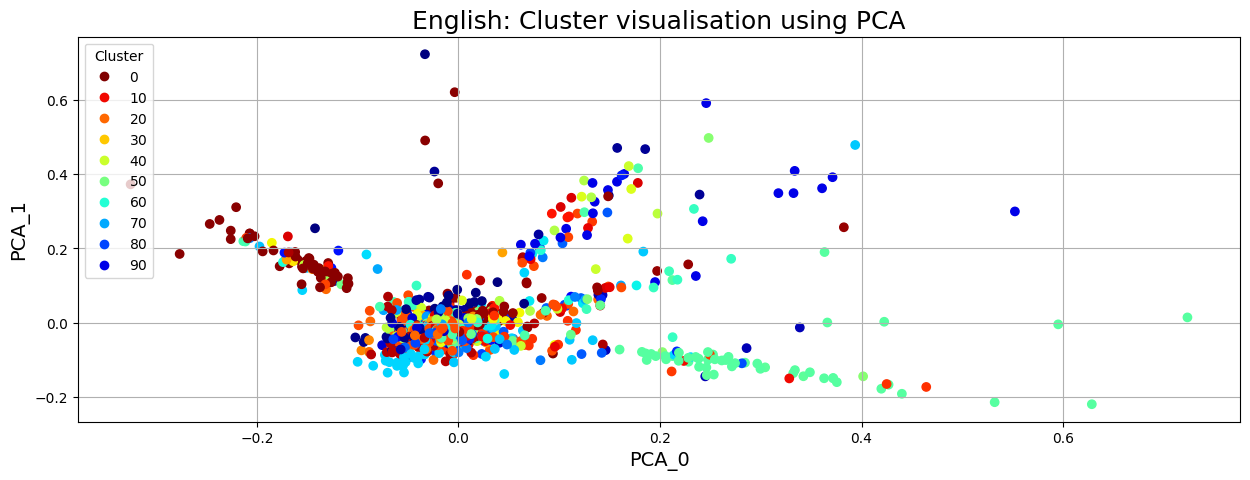

In [40]:
plot_pca(english_pca, english_cluster_labels_sample, language='English')

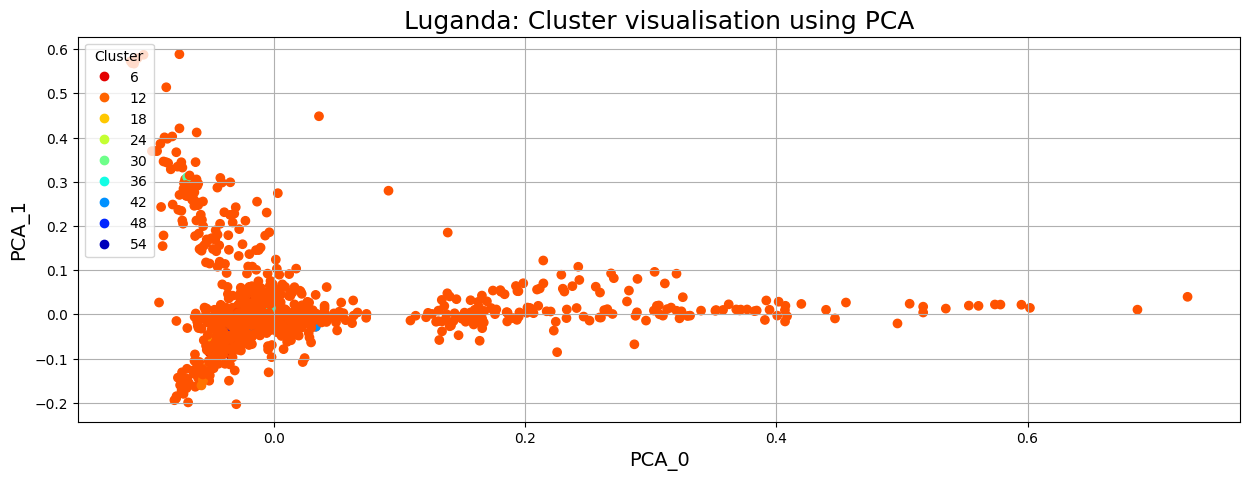

In [41]:
plot_pca(luganda_pca, luganda_cluster_labels_sample, language='Luganda')

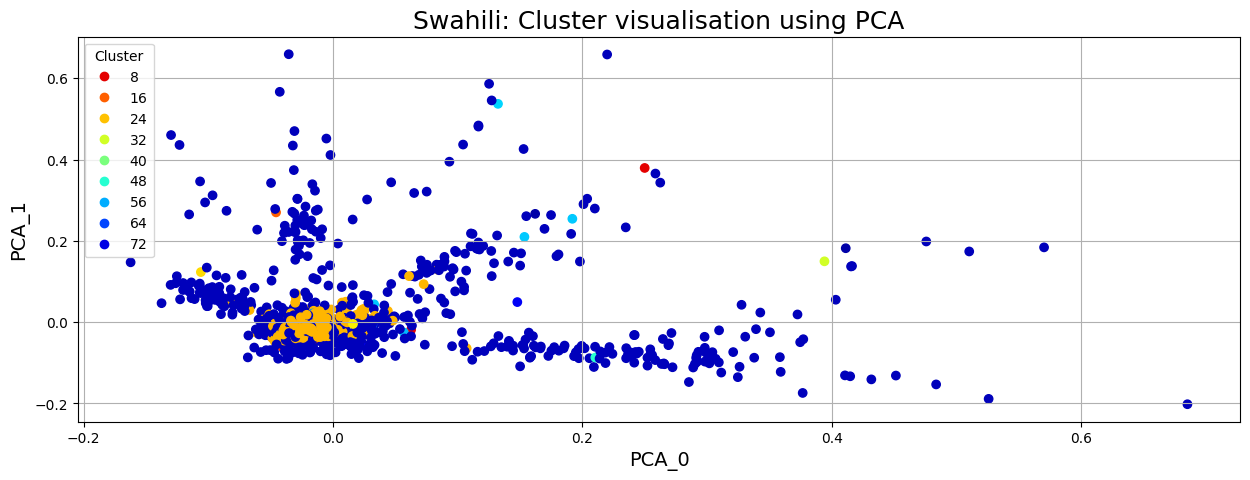

In [42]:
plot_pca(swahili_pca, swahili_cluster_labels_sample, language='Swahili')

#### Plot tsne

In [43]:
import plotly.express as px

def plot_tsne(X_df_samples, language='English'):
    """
    Visualises clusters using a 2D t-SNE plot with Plotly.
    
    - Notes:
        - This function creates a t-SNE plot with `tsne_0` and `tsne_1` as the x and y axes to visualise clusters in 2D space.
        - Data points are color-coded based on cluster labels, and hover information can include additional metadata.
        - The interactive Plotly visualisation allows zooming and hovering for detailed cluster exploration.
        - The legend order is reversed to ensure clusters appear in a specified sequence.

    Args:
        X_df_samples (pandas.DataFrame): DataFrame containing t-SNE components (`tsne_0` and `tsne_1`), cluster labels, and optional language-specific metadata for hover information.
        language (str): Label for the plot title, indicating the dataset or language being analyzed (default is 'English').

    Returns:
        None: Displays an interactive 2D t-SNE scatter plot with clusters color-coded and hover details provided by Plotly Express.
    """
    fig = px.scatter(X_df_samples,x="tsne_0",y="tsne_1",
                     color="cluster_labels", hover_data=f"{language}",height = 720,
                    title=f"{language}: Cluster visualisation using TSNE - plotly")
    fig.update_layout(legend_traceorder="reversed")
    fig.show()

In [44]:
english_df_samples["tsne_0"] = english_tsne[:,0]
english_df_samples["tsne_1"] = english_tsne[:,1]
np.sort(english_df_samples["cluster_labels"].unique())   
plot_tsne(english_df_samples, 'English')

In [45]:
luganda_df_samples["tsne_0"] = luganda_tsne[:,0]
luganda_df_samples["tsne_1"] = luganda_tsne[:,1]
np.sort(luganda_df_samples["cluster_labels"].unique())   
plot_tsne(luganda_df_samples, 'Luganda')

In [46]:
swahili_df_samples["tsne_0"] = swahili_tsne[:,0]
swahili_df_samples["tsne_1"] = swahili_tsne[:,1]
np.sort(swahili_df_samples["cluster_labels"].unique())   
plot_tsne(swahili_df_samples, 'Swahili')

#### Get top words

In [47]:
## Helper function to get the top words per cluster
def get_top_keywords(X, clusters, labels, n_terms):
    """
    Retrieves and displays the top keywords for each cluster based on TF-IDF scores.
    
    - Notes:
        - The function converts the sparse TF-IDF matrix `X` to a dense format for processing.
        - Clusters are grouped, and the mean TF-IDF score for each term is calculated per cluster.
        - For each cluster, the top `n_terms` keywords with the highest average TF-IDF scores are displayed.

    Args:
        X (scipy.sparse matrix): TF-IDF matrix of the dataset, where each row represents a document and each column a term.
        clusters (array): Array of cluster labels corresponding to each document in X, used for grouping documents.
        labels (list of str): List of term labels corresponding to the columns in X (i.e., vocabulary terms).
        n_terms (int): Number of top terms to display for each cluster based on average TF-IDF score.

    Returns:
        None: Prints the top keywords for each cluster, sorted by relevance according to mean TF-IDF scores.
    """
    df = pd.DataFrame(X.todense()) # Convert our data TFIDF data to a dataframe
    df = df.groupby(clusters).mean() # Group by clusters and calculate the mean per feature (word)

    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]])) #Show te top n_terms as per TFIDF

In [48]:
get_top_keywords(english_tfidf_sample, english_cluster_labels_sample, english_vectorizer_tfidf.get_feature_names_out(), 10)


Cluster 0
faulty,fault,father,fatal,fat,faster,hate,people,much,talk

Cluster 1
feel,day,keeping,lawyer,care,get,quality,look,reason,good

Cluster 2
called,husband,receive,school,make,mother,today,feel,child,happy

Cluster 4
quite,storybook,newspaper,supporter,turned,smart,amazing,drawing,look,picture

Cluster 5
dropped,girl,son,pay,sister,broke,refused,got,school,angry

Cluster 6
series,weak,action,abusive,drive,respond,criticize,typing,mistreatment,tired

Cluster 7
young,birthday,lot,money,finally,present,able,machine,cost,buy

Cluster 8
simple,importance,funniest,healthy,unfair,people,today,day,living,life

Cluster 9
mother,poem,cheerful,suffer,funny,feel,decision,party,laugh,made

Cluster 10
enjoyed,relaxing,rest,love,fellowship,wonderful,lousy,family,shopping,weekend

Cluster 11
puncture,monday,repeated,four,two,fallen,happy,day,worst,week

Cluster 13
encountered,toy,foreigner,lost,died,sadly,war,advantage,people,many

Cluster 14
happy,one,student,watched,town,movie,ever,know,fri

In [49]:
get_top_keywords(luganda_tfidf_sample, luganda_cluster_labels_sample, luganda_vectorizer_tfidf.get_feature_names_out(), 10)


Cluster 1
eziyingizibwa,eziyigiriza,eziyakaayakana,eziwoggana,eziwera,ezitwala,ezzaamu,omwana,omulungi,mmwagala

Cluster 3
eziwera,ezitwala,ezituyingiza,ezituuyanye,mtn,amayengo,nsobeddwa,mpuubadde,mpulira,olwaleero

Cluster 4
ng,okukola,yawulidde,akooye,nkooye,lw,okugenda,kifo,ewakolerwa,dduyiro

Cluster 5
eziyakaayakana,eziwoggana,eziwera,ezitwala,basanyufu,eri,bakasitoma,kompyuta,omupya,omuyungo

Cluster 10
ezituyingiza,ezituukira,we,eya,yawulira,obusungu,waggulu,muliraanwa,bbeeyi,emicungwa

Cluster 11
basanyufu,olw,lw,abaana,eky,ennaku,ndi,kubanga,musanyufu,ng

Cluster 13
omupiira,okubaka,nanyumirwa,twanyumirwa,emizannyo,okweraliikirira,ya,ewedde,nkomerero,wiiki

Cluster 15
mangu,kitaabwe,akomyewo,lw,ebyennyanja,basanyufu,abavubi,olunaku,eggulo,baabadde

Cluster 17
eziwera,ezitwala,ezituyingiza,ezituuyanye,ezituukira,ezitutwala,ezitta,olunaku,olwaleero,olulungi

Cluster 18
eziyingizibwa,eziyigiriza,eziyakaayakana,eziwoggana,eziwera,ezitwala,ezituyingiza,ezituuyanye,omulwadde,kooko

In [50]:
get_top_keywords(swahili_tfidf_sample, swahili_cluster_labels_sample, swahili_vectorizer_tfidf.get_feature_names_out(), 10)


Cluster 1
kuendana,kudundika,kudumu,kudumisha,kudukuliwa,kuendesha,ana,maumivu,makali,kichwa

Cluster 2
kudharauliwa,kuelekea,kueleimisha,kuegesha,kudundika,kudumu,kudumisha,kudukuliwa,filamu,kuhuzunisha

Cluster 4
kudundika,kudumu,kudumisha,airtel,simu,huduma,njia,kifedha,zipo,tozo

Cluster 8
kudukuliwa,kudharauliwa,kudeki,kwasababu,mbaya,nimefurahi,kesho,siku,kumbukizi,kuzaliwa

Cluster 10
kudundika,kudumu,kudumisha,kudukuliwa,kudharauliwa,kudaiwa,kula,sipendi,kukaanga,wali

Cluster 11
kudharauliwa,kudeki,kudaiwa,kuchunga,yenye,biashara,rahisi,kutegemewa,mtn,mtandaoni

Cluster 12
kudumisha,kudukuliwa,kuendana,alikasirika,baridi,supu,kitamu,wangu,mrembo,mpenzi

Cluster 13
kudumu,kudumisha,kudukuliwa,kudharauliwa,kudaiwa,lake,lilikuwa,hilus,zuri,tamasha

Cluster 16
kueleimisha,kuegesha,kudundika,kudumu,kudumisha,kudukuliwa,kudharauliwa,kazi,nzuri,jitahidi

Cluster 23
alikasirika,yako,marafiki,zangu,sahihi,hatari,kula,lile,bora,alifurahi

Cluster 26
kudumu,kudumisha,kudukuliwa,ile,simu

In [51]:
from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from sklearn.cluster import KMeans
import pylab as pl
%matplotlib inline

In [52]:
english_df = data_df.copy()
english_df = english_df.drop(columns=['Luganda', 'Swahili'])
english_df['klabels'] = english_cluster_labels
english_df

English Sentiment  \
0                       friend enjoyed party last night       Pos   
1            rejoiced uncle stay germany invited u join       Pos   
2              manager angry reached past eight morning       Neg   
3     last friday felt embarrassed secretary disresp...       Neg   
4     felt disappointed father failed attend graduat...       Neg   
...                                                 ...       ...   
9995                  sadly old woman hip fracture fell       Neg   
9996                     love putting short going beach       Pos   
9997               cousin refused sit final examination       Neg   
9998            happy sat silence meditated god 's work       Pos   
9999                         one favorite shopping mall       Pos   

      Sentiment Encoded  klabels  
0                     1       66  
1                     1       62  
2                     0        5  
3                     0       64  
4                     0       45  
...                 ...      ...  
9995                  0       70  
9996                  1       54  
9997                  0       77  
9998                  1       99  
9999                  1       63  

[9997 rows x 4 columns]

In [53]:
luganda_df = data_df.copy()
luganda_df = luganda_df.drop(columns=['English', 'Swahili'])
luganda_df['klabels'] = luganda_cluster_labels
luganda_df

Luganda Sentiment  \
0     mikwano gyange gyanyumiddwa akabaga ekiro ekya...       Pos   
1     twajaganya kojjaffe abeera bugirimaani atuyise...       Pos   
2     maneja yali musunguwavu gyendi natuuka ng'obud...       Neg   
3     olwokutaano oluwedde nawulira nswadde omuwandi...       Neg   
4            yeewuunya kitaawe alemereddwa matikkira ge       Neg   
...                                                 ...       ...   
9995  eky'ennaku omukyala omukadde yanuuse ekisambi ...       Neg   
9996           ayagala okwambala ebinu ng'agenda bbiici       Pos   
9997  kizibwe yagaanye okutuula ebigezo eby'akamalirizo       Neg   
9998  musanyufu twatudde tusiriikirira twefumintiriz...       Pos   
9999       kimu bizimbe by'amaduuka bye nsinga okwagala       Pos   

      Sentiment Encoded  klabels  
0                     1       11  
1                     1       11  
2                     0       11  
3                     0       11  
4                     0       11  
...                 ...      ...  
9995                  0       11  
9996                  1       11  
9997                  0       11  
9998                  1       11  
9999                  1       11  

[9997 rows x 4 columns]

In [54]:
swahili_df = data_df.copy()
swahili_df = swahili_df.drop(columns=['English', 'Luganda'])
swahili_df['klabels'] = swahili_cluster_labels
swahili_df

Swahili Sentiment  \
0         marafiki wangu walifurahia sherehe jana usiku       Pos   
1     tulifurahi mjomba wetu anayeishi ujerumani ali...       Pos   
2     meneja alinikasirikia nilivyofika saa mbili as...       Neg   
3     ijumaa ilyopita nilijihisi aibu katibu muhtasi...       Neg   
4     alikosa furaha baba aliposhindwa kuhudhuria ma...       Neg   
...                                                 ...       ...   
9995  inasikitisha mwanamama huyo mzee alivunjika ny...       Neg   
9996          anapenda kuvaa nguo fupi aendapo ufukweni       Pos   
9997            binamu alikataa kufanya mitihani mwisho       Neg   
9998   nilifurahi tulipokaa kimya kutafakari kazi mungu       Pos   
9999                   hilus maduka makubwa niyapendayo       Pos   

      Sentiment Encoded  klabels  
0                     1       75  
1                     1       23  
2                     0       23  
3                     0       23  
4                     0       75  
...                 ...      ...  
9995                  0       23  
9996                  1       23  
9997                  0       75  
9998                  1       75  
9999                  1       23  

[9997 rows x 4 columns]

#### Apply the pipeline

In [55]:
import time

def apply_pca_tsne_pipeline(X_tfidf, language='English'):
    """
    Applies a PCA and t-SNE pipeline to reduce the dimensionality of TF-IDF data.
    
    - Notes:
        - This function first applies PCA to reduce the dimensionality while retaining 90% of the variance.
        - It then applies t-SNE to further reduce the data to two dimensions for effective visualisation.
        - The function prints the time taken for the entire pipeline to execute.
        - PCA improves computational efficiency for t-SNE, especially for high-dimensional data.
        
    - Pipeline Parameters:
        - PCA: Retains 90% of variance in the dataset.
        - t-SNE: Uses a perplexity of 170, learning rate of 350, 5000 iterations, and halts after 150 iterations without progress.

    Args:
        X_tfidf (scipy.sparse matrix or numpy array): TF-IDF matrix of the dataset, where each row represents a document and each column a term.
        language (str): Language label used for informational output (default is 'English').

    Returns:
        numpy.ndarray: 2D array of transformed data, reduced to two dimensions for visualisation.
    """
    print(f"Applying pipeline on {language} data:")
    pca_tsne= Pipeline([("pca", PCA(n_components= 0.90, random_state=33)),
                        ("tsne", TSNE(n_components=2,
                                      perplexity= 170,
                                      random_state=33, 
                                      learning_rate= 350, 
                                      n_iter= 5000,
                                      n_jobs=-1,
                                      n_iter_without_progress=150,
                                      verbose=1))])
    t0= time.time()
    df_pca_tsne_reduced= pca_tsne.fit_transform(X_tfidf.toarray())
    t1= time.time()
    
    print("pca+tsne took:{:.1f}s ".format(t1-t0))
    
    return df_pca_tsne_reduced

In [56]:
english_df_pca_tsne_reduced = apply_pca_tsne_pipeline(english_tfidf, 'English')

Applying pipeline on English data:
[t-SNE] Computing 511 nearest neighbors...
[t-SNE] Indexed 9997 samples in 0.107s...
[t-SNE] Computed neighbors for 9997 samples in 5.077s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9997
[t-SNE] Computed conditional probabilities for sample 2000 / 9997
[t-SNE] Computed conditional probabilities for sample 3000 / 9997
[t-SNE] Computed conditional probabilities for sample 4000 / 9997
[t-SNE] Computed conditional probabilities for sample 5000 / 9997
[t-SNE] Computed conditional probabilities for sample 6000 / 9997
[t-SNE] Computed conditional probabilities for sample 7000 / 9997
[t-SNE] Computed conditional probabilities for sample 8000 / 9997
[t-SNE] Computed conditional probabilities for sample 9000 / 9997
[t-SNE] Computed conditional probabilities for sample 9997 / 9997
[t-SNE] Mean sigma: 0.370433
[t-SNE] KL divergence after 250 iterations with early exaggeration: 103.373970
[t-SNE] KL divergence after 5000 iterations: 3.020459
p

In [57]:
luganda_df_pca_tsne_reduced = apply_pca_tsne_pipeline(luganda_tfidf, 'Luganda')

Applying pipeline on Luganda data:
[t-SNE] Computing 511 nearest neighbors...
[t-SNE] Indexed 9997 samples in 0.128s...
[t-SNE] Computed neighbors for 9997 samples in 5.898s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9997
[t-SNE] Computed conditional probabilities for sample 2000 / 9997
[t-SNE] Computed conditional probabilities for sample 3000 / 9997
[t-SNE] Computed conditional probabilities for sample 4000 / 9997
[t-SNE] Computed conditional probabilities for sample 5000 / 9997
[t-SNE] Computed conditional probabilities for sample 6000 / 9997
[t-SNE] Computed conditional probabilities for sample 7000 / 9997
[t-SNE] Computed conditional probabilities for sample 8000 / 9997
[t-SNE] Computed conditional probabilities for sample 9000 / 9997
[t-SNE] Computed conditional probabilities for sample 9997 / 9997
[t-SNE] Mean sigma: 0.424288
[t-SNE] KL divergence after 250 iterations with early exaggeration: 158.749451
[t-SNE] KL divergence after 2600 iterations: 3.187729
p

In [58]:
swahili_df_pca_tsne_reduced = apply_pca_tsne_pipeline(swahili_tfidf, 'Swahili')

Applying pipeline on Swahili data:
[t-SNE] Computing 511 nearest neighbors...
[t-SNE] Indexed 9997 samples in 0.125s...
[t-SNE] Computed neighbors for 9997 samples in 5.764s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9997
[t-SNE] Computed conditional probabilities for sample 2000 / 9997
[t-SNE] Computed conditional probabilities for sample 3000 / 9997
[t-SNE] Computed conditional probabilities for sample 4000 / 9997
[t-SNE] Computed conditional probabilities for sample 5000 / 9997
[t-SNE] Computed conditional probabilities for sample 6000 / 9997
[t-SNE] Computed conditional probabilities for sample 7000 / 9997
[t-SNE] Computed conditional probabilities for sample 8000 / 9997
[t-SNE] Computed conditional probabilities for sample 9000 / 9997
[t-SNE] Computed conditional probabilities for sample 9997 / 9997
[t-SNE] Mean sigma: 0.408267
[t-SNE] KL divergence after 250 iterations with early exaggeration: 139.722000
[t-SNE] KL divergence after 1950 iterations: 3.189356
p

#### Plot pipeline

In [59]:
import seaborn as sns

def plot_pca_tsne_pipeline_data_plotly(df_pca_tsne_reduced, labels, language='English'):
    """
    Creates a scatter plot of PCA and t-SNE transformed data using Plotly for visualisation.

    - Notes:
        - Converts PCA and t-SNE output to a DataFrame for compatibility with Plotly Express.
        - Displays an interactive scatter plot, with points color-coded based on their labels.
        - Useful for visualising clustering results or dimensionality-reduced data.
    
    Args:
        df_pca_tsne_reduced (numpy.ndarray): 2D array with PCA and t-SNE reduced data, where each row represents a data point.
        labels (list or array): Cluster or category labels for each data point, used to color-code points in the plot.
        language (str): Language label used in the plot title (default is 'English').

    Returns:
        None: Displays an interactive scatter plot in Plotly.
    """
    # Convert to DataFrame for Plotly compatibility
    df_plot = pd.DataFrame(df_pca_tsne_reduced, columns=['Component 1', 'Component 2'])
    df_plot['Labels'] = labels

    # Create scatter plot using Plotly Express
    fig = px.scatter(df_plot, x='Component 1', y='Component 2',
                     title=f'{language}: PCA + t-SNE Scatter Plot',
                     labels={'Component 1': 'Component 1', 'Component 2': 'Component 2'})

    fig.show()

In [60]:
plot_pca_tsne_pipeline_data_plotly(english_df_pca_tsne_reduced, None, language='English')

In [61]:
plot_pca_tsne_pipeline_data_plotly(luganda_df_pca_tsne_reduced, None, language='Luganda')

In [62]:
plot_pca_tsne_pipeline_data_plotly(swahili_df_pca_tsne_reduced, None, language='Swahili')

#### Fit on reduced data

In [63]:
def fit_on_pca_tsne_reduced(df_pca_tsne_reduced, X_clf):
    """
    Fits a classifier on PCA and t-SNE reduced data and returns the predicted labels.
    
    - Notes:
        - The classifier is fitted on the provided reduced data (`df_pca_tsne_reduced`).
        - The function returns the predicted labels as `X_clf.labels_`.
        - This function assumes that `X_clf` is a model with the `fit()` and `labels_` attributes (e.g., clustering models such as KMeans or other classifiers).
    
    Args:
        df_pca_tsne_reduced (numpy.ndarray or pandas.DataFrame): The PCA and t-SNE reduced data to fit the classifier on.
        X_clf (object): A classifier object that supports the `fit()` method, such as a clustering algorithm or classification model.

    Returns:
        numpy.ndarray: The predicted labels from the classifier after fitting to the reduced data.
    """
    -1*X_clf.fit(df_pca_tsne_reduced).score(df_pca_tsne_reduced)
    y_pred= X_clf.labels_
    return X_clf.labels_

In [64]:
# Assigning cluster labels to each data point
english_df['klabels'] = fit_on_pca_tsne_reduced(english_df_pca_tsne_reduced, english_clf)

In [65]:
luganda_df['klabels'] = fit_on_pca_tsne_reduced(luganda_df_pca_tsne_reduced, luganda_clf)

In [66]:
swahili_df['klabels'] = fit_on_pca_tsne_reduced(swahili_df_pca_tsne_reduced, swahili_clf)

#### Get size of each cluster

In [67]:
# Analysing 
def get_size_of_each_cluster(X_df):
     """
    Computes the size and percentage of points in each cluster from a given dataframe.
    
    - Notes:
        - The function assumes the dataframe `X_df` contains a column 'klabels' for the cluster assignments.
        - It calculates the number of points per cluster and the corresponding percentage of the total data.
        - The function prints and returns a dataframe with three columns: 'klabels', 'number_of_points', and 'percentage'.

    Args:
        X_df (pandas.DataFrame): A dataframe containing a column 'klabels' which represents cluster labels.

    Returns:
        pandas.DataFrame: A dataframe with the cluster labels, the number of points in each cluster, and the percentage of the total data points that belong to each cluster.
    """
    size_of_each_cluster= X_df.groupby('klabels').size().reset_index()
    size_of_each_cluster.columns = ['klabels','number_of_points']
    size_of_each_cluster['percentage'] = (size_of_each_cluster['number_of_points']/np.sum(size_of_each_cluster['number_of_points']))*100

    print(size_of_each_cluster)
    return size_of_each_cluster

In [68]:
english_size_of_each_cluster = get_size_of_each_cluster(english_df)

    klabels  number_of_points  percentage
0         0                88    0.880264
1         1               118    1.180354
2         2               125    1.250375
3         3                79    0.790237
4         4                34    0.340102
..      ...               ...         ...
95       95               128    1.280384
96       96               111    1.110333
97       97                82    0.820246
98       98                98    0.980294
99       99                39    0.390117

[100 rows x 3 columns]


In [69]:
luganda_size_of_each_cluster = get_size_of_each_cluster(luganda_df)

    klabels  number_of_points  percentage
0         0               249    2.490747
1         1               202    2.020606
2         2               106    1.060318
3         3               223    2.230669
4         4               141    1.410423
5         5               149    1.490447
6         6               133    1.330399
7         7               170    1.700510
8         8               160    1.600480
9         9               140    1.400420
10       10               211    2.110633
11       11               111    1.110333
12       12               220    2.200660
13       13               111    1.110333
14       14               126    1.260378
15       15                82    0.820246
16       16               128    1.280384
17       17               221    2.210663
18       18                94    0.940282
19       19               203    2.030609
20       20               294    2.940882
21       21               177    1.770531
22       22                78    0

In [70]:
swahili_size_of_each_cluster = get_size_of_each_cluster(swahili_df)

    klabels  number_of_points  percentage
0         0               226    2.260678
1         1               115    1.150345
2         2                93    0.930279
3         3               136    1.360408
4         4               125    1.250375
..      ...               ...         ...
75       75                29    0.290087
76       76               247    2.470741
77       77                52    0.520156
78       78                89    0.890267
79       79               110    1.100330

[80 rows x 3 columns]


#### Visualise clusters

In [71]:
def visualise_tsne_with_kmeans_labels(df_pca_tsne_reduced, X_df, language='English'):
    """
    Visualises the t-SNE reduced data with KMeans clustering labels using a scatter plot.
    - Notes:
        - The function assumes `X_df` contains a column 'klabels' for the cluster labels obtained from KMeans.
        - The plot is created using Seaborn with clusters distinguished by color.
        - The function uses `sns.scatterplot` to create the plot, with a custom color palette based on the number of unique clusters.
        - The plot is titled "t-sne with KMeans labels" and the legend is positioned in the upper-left corner.

    Args:
        df_pca_tsne_reduced (numpy.ndarray): A 2D numpy array with t-SNE reduced data (two components).
        X_df (pandas.DataFrame): A dataframe that contains the 'klabels' column with KMeans cluster labels.
        language (str, optional): The language for the plot's title (default is 'English').

    Returns:
        None: This function displays a scatter plot but does not return any value.
    """
    y_pred = X_df['klabels']
    palette = sns.hls_palette(len(y_pred.unique()), l=.4, s=.9)

    sns.set(rc= {'figure.figsize': (13,13)})
    ax = sns.scatterplot(x=df_pca_tsne_reduced[:,0], y=df_pca_tsne_reduced[:,1], hue= y_pred, legend='full', palette=palette)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=3)
    # ax.legend(ncol=4)
    ax.set_title("t-sne with KMeans labels")
    plt.show()

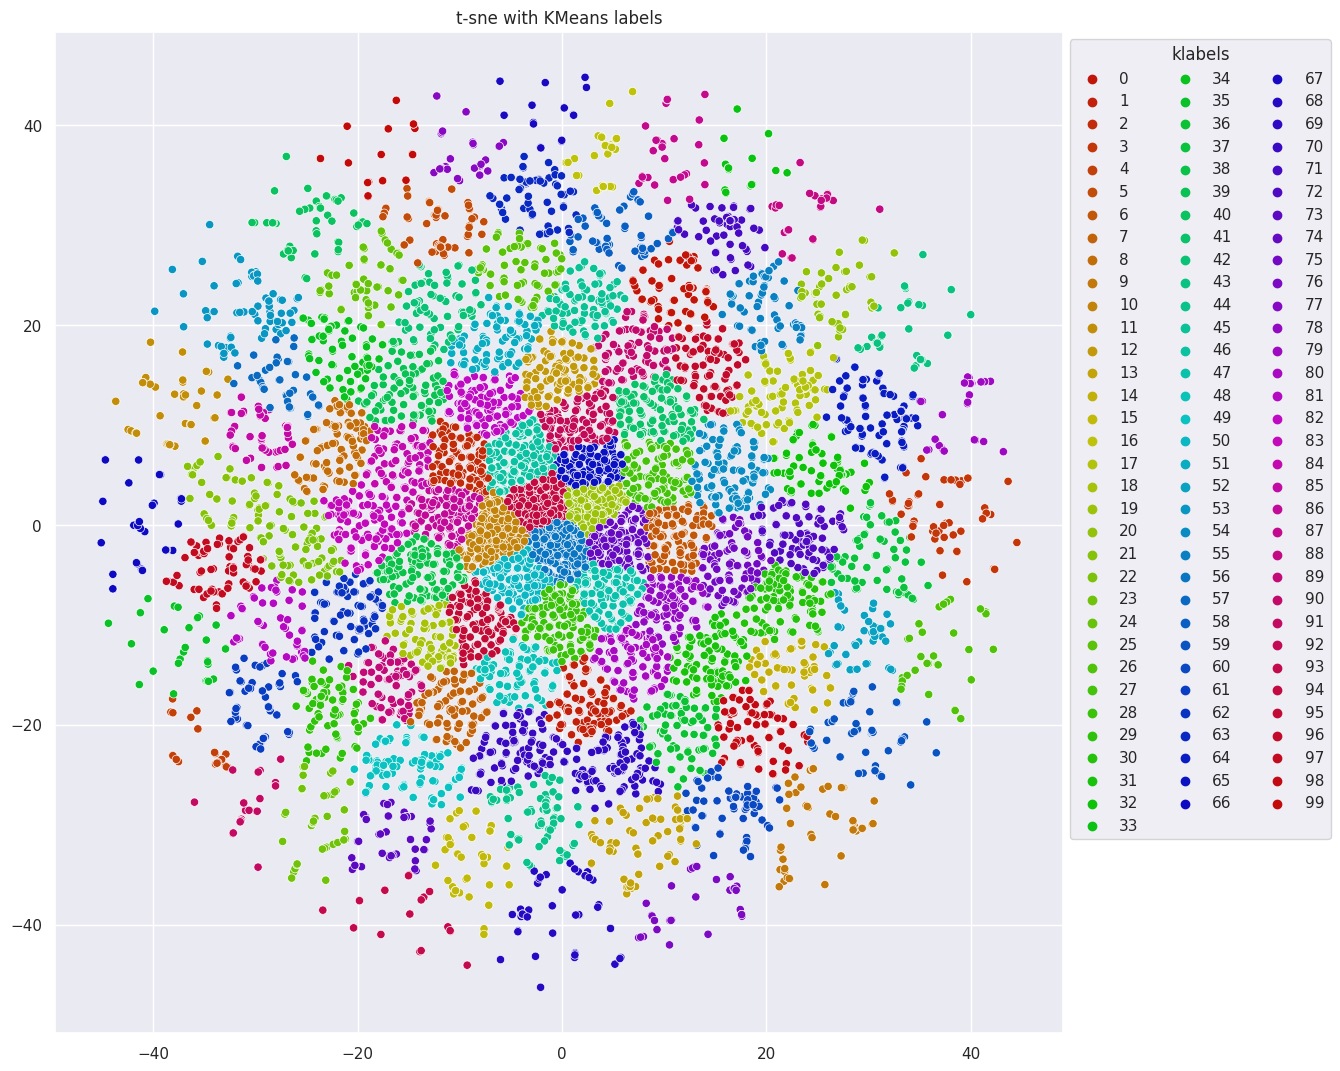

In [72]:
visualise_tsne_with_kmeans_labels(english_df_pca_tsne_reduced, english_df, 'English')

In [73]:
from sklearn.metrics import silhouette_score

silhouette_score(english_tfidf, english_df['klabels']) # Have look at english_df_pca_tsne_reduced instead of english_tfidf

0.005504102653094695

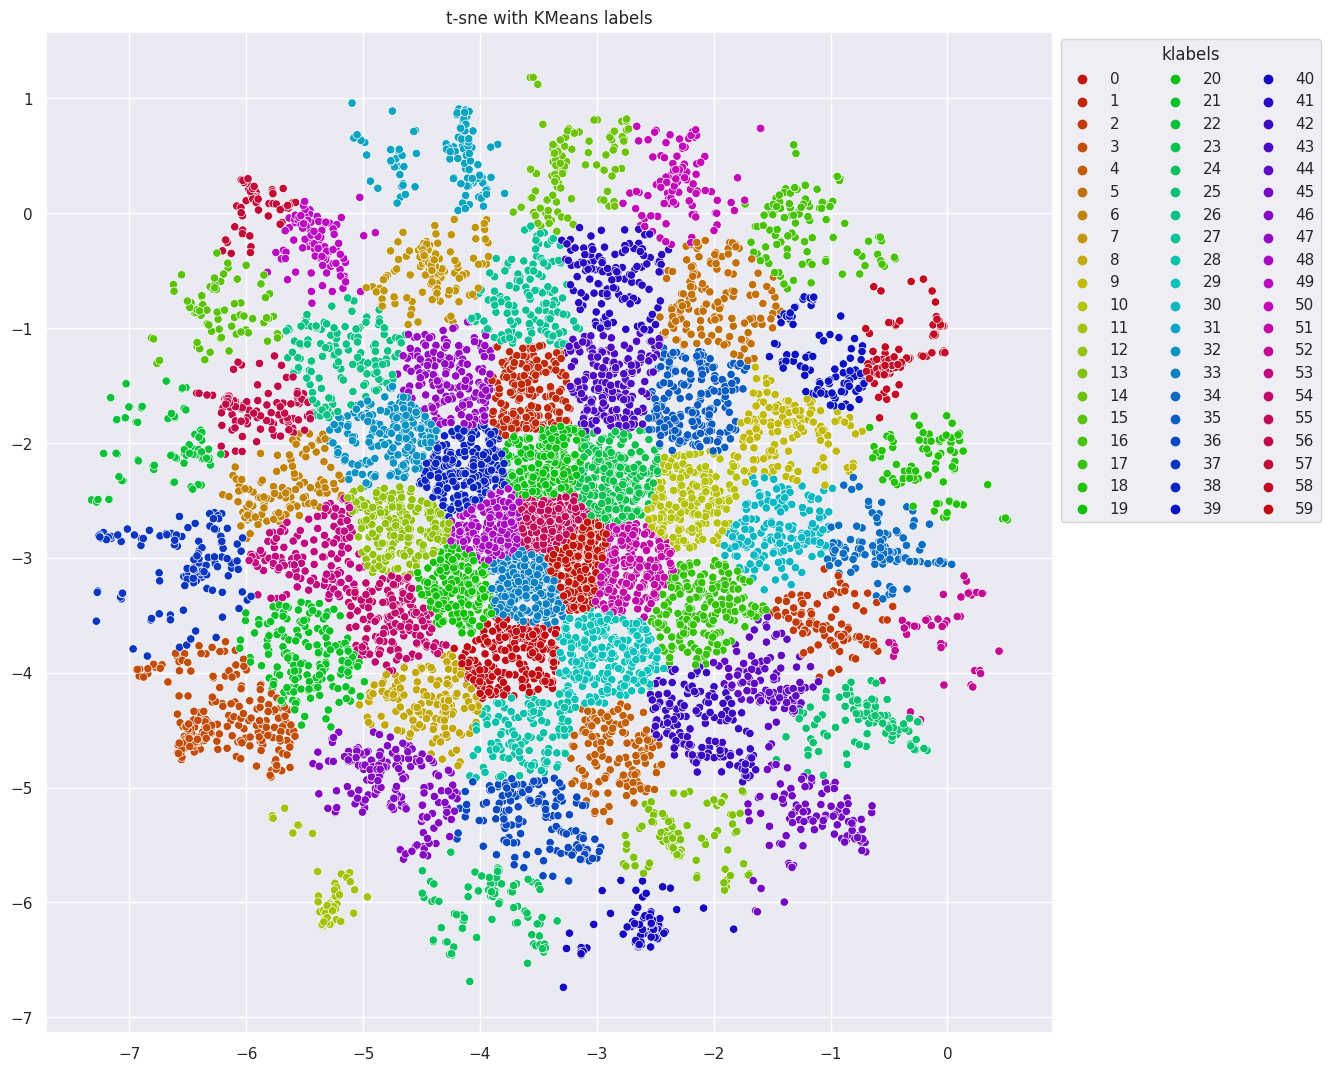

In [74]:
visualise_tsne_with_kmeans_labels(luganda_df_pca_tsne_reduced, luganda_df, 'Luganda')

In [75]:
silhouette_score(luganda_tfidf, luganda_df['klabels'])

-0.003283443627294703

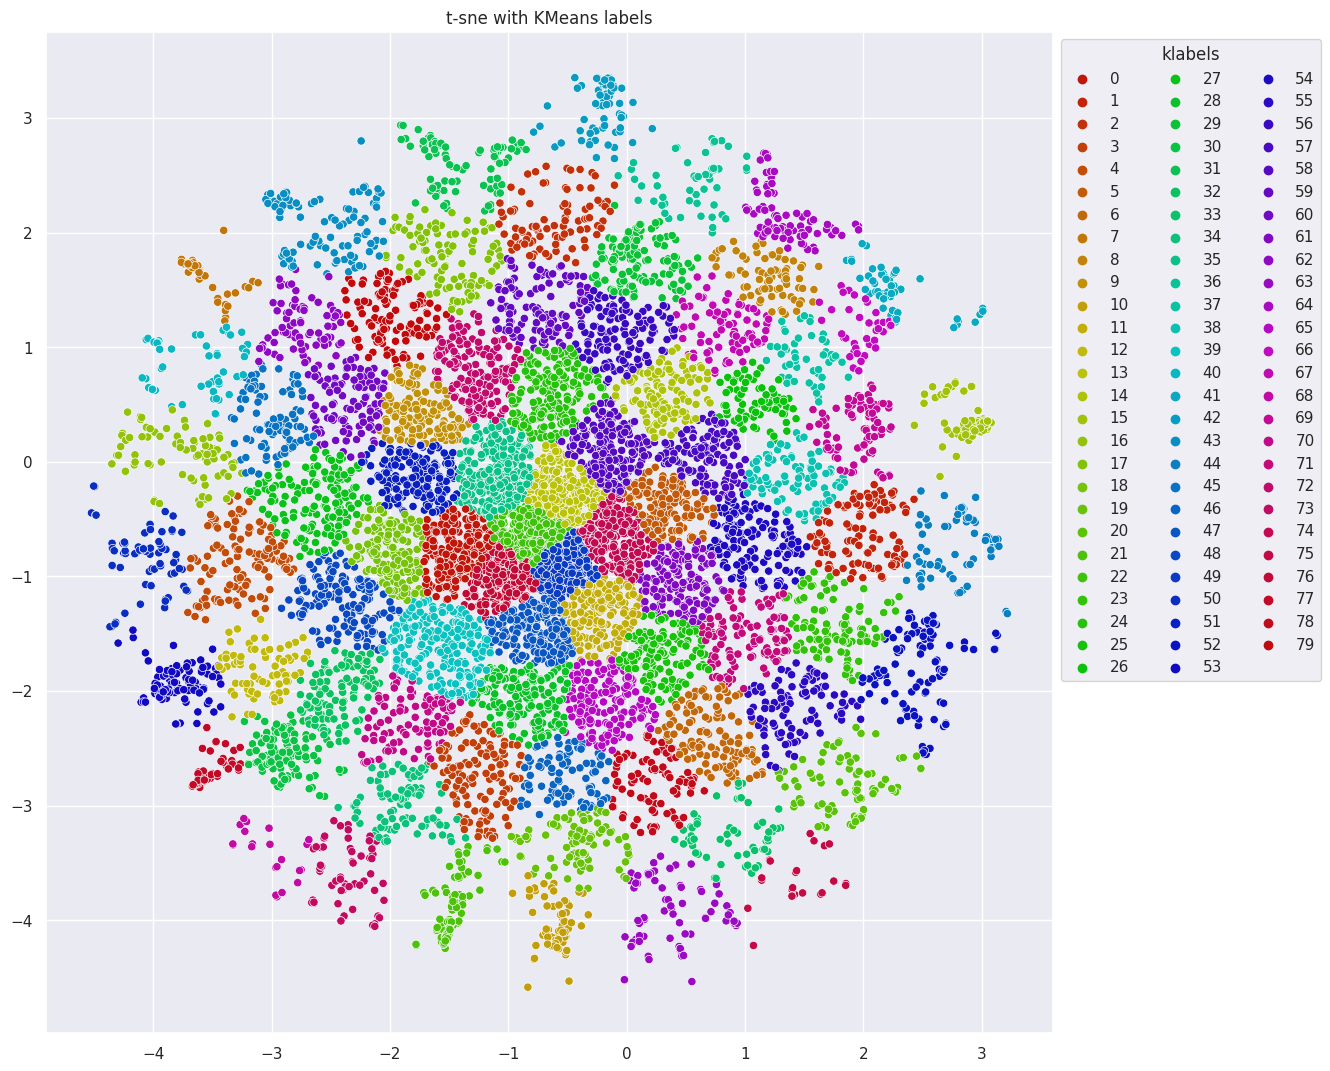

In [76]:
visualise_tsne_with_kmeans_labels(swahili_df_pca_tsne_reduced, swahili_df, 'Swahili')

In [77]:
silhouette_score(swahili_tfidf, swahili_df['klabels'])

-0.004661631778760838

# Topic Modeling- Latent Dirichlet Allocation(LDA)

## Step 1: Preprocessing (we've already done it at the start of this notebook)

In [78]:
# view preprocessing code located before performing clustering tasks

## Step 2: More data cleaning. We procure only nouns and adjectives to obtain meaningful topics

In [79]:
def clean_dataframe(X_df, language='English'):
    """
    Cleans the dataframe by splitting text data into arrays of words.
    - Notes:
        - The function assumes that the text data in the specified language column is a string.
        - Each text entry in the specified column is split into individual words, creating a numpy array for each entry.

    Args:
        X_df (pandas.DataFrame): A dataframe containing a column with text data.
        language (str, optional): The language column to be processed (default is 'English').

    Returns:
        pandas.Series: A series containing arrays of words for each row in the specified language column.
    """
    # Create arrays in the dataframe
    clean_X_df = X_df[language].apply(lambda x: np.array(x.split()))
    return clean_X_df

In [80]:
clean_english_df = clean_dataframe(english_df, 'English')
clean_english_df

0                   [friend, enjoyed, party, last, night]
1       [rejoiced, uncle, stay, germany, invited, u, j...
2         [manager, angry, reached, past, eight, morning]
3       [last, friday, felt, embarrassed, secretary, d...
4       [felt, disappointed, father, failed, attend, g...
                              ...                        
9995             [sadly, old, woman, hip, fracture, fell]
9996                 [love, putting, short, going, beach]
9997           [cousin, refused, sit, final, examination]
9998      [happy, sat, silence, meditated, god, 's, work]
9999                      [one, favorite, shopping, mall]
Name: English, Length: 9997, dtype: object

In [81]:
clean_luganda_df = clean_dataframe(luganda_df, 'Luganda')
clean_luganda_df

0       [mikwano, gyange, gyanyumiddwa, akabaga, ekiro...
1       [twajaganya, kojjaffe, abeera, bugirimaani, at...
2       [maneja, yali, musunguwavu, gyendi, natuuka, n...
3       [olwokutaano, oluwedde, nawulira, nswadde, omu...
4        [yeewuunya, kitaawe, alemereddwa, matikkira, ge]
                              ...                        
9995    [eky'ennaku, omukyala, omukadde, yanuuse, ekis...
9996       [ayagala, okwambala, ebinu, ng'agenda, bbiici]
9997    [kizibwe, yagaanye, okutuula, ebigezo, eby'aka...
9998    [musanyufu, twatudde, tusiriikirira, twefumint...
9999    [kimu, bizimbe, by'amaduuka, bye, nsinga, okwa...
Name: Luganda, Length: 9997, dtype: object

In [82]:
clean_swahili_df = clean_dataframe(swahili_df, 'Swahili')
clean_swahili_df

0       [marafiki, wangu, walifurahia, sherehe, jana, ...
1       [tulifurahi, mjomba, wetu, anayeishi, ujeruman...
2       [meneja, alinikasirikia, nilivyofika, saa, mbi...
3       [ijumaa, ilyopita, nilijihisi, aibu, katibu, m...
4       [alikosa, furaha, baba, aliposhindwa, kuhudhur...
                              ...                        
9995    [inasikitisha, mwanamama, huyo, mzee, alivunji...
9996     [anapenda, kuvaa, nguo, fupi, aendapo, ufukweni]
9997        [binamu, alikataa, kufanya, mitihani, mwisho]
9998    [nilifurahi, tulipokaa, kimya, kutafakari, kaz...
9999                [hilus, maduka, makubwa, niyapendayo]
Name: Swahili, Length: 9997, dtype: object

#### Install necessary files to get POS tags for Luganda and Swahili
First install [masakhane-pos](https://github.com/masakhane-io/masakhane-pos)

In [83]:
!wget https://raw.githubusercontent.com/masakhane-io/masakhane-pos/main/utils.py -O utils.py

--2024-11-06 08:07:55--  https://raw.githubusercontent.com/masakhane-io/masakhane-pos/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8928 (8.7K) [text/plain]
Saving to: 'utils.py'

utils.py            100%[===================>]   8.72K  --.-KB/s    in 0s      

2024-11-06 08:07:55 (74.6 MB/s) - 'utils.py' saved [8928/8928]



In [84]:
from utils import get_labels

In [85]:
get_labels('')

['X',
 'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB']

#### Load Luganda and Swahili files containing POS Tags

In [86]:
# Function to load POS tags from GitHub raw URLs
def load_pos_tags_from_github(file_urls):
    """
    Loads part-of-speech (POS) tags from raw text files available on GitHub URLs.
    - Notes:
        - Each file should contain word-tag pairs separated by whitespace, with one pair per line.
        - The function assumes the POS tags and words are space-separated in the file.

    Args:
        file_urls (list of str): A list of URLs pointing to raw text files containing word-tag pairs.

    Returns:
        list of tuple: A list of tuples, where each tuple contains a word and its corresponding POS tag.
    """
    words_tags = []
    for url in file_urls:
        response = requests.get(url)
        for line in response.text.splitlines():
            line = line.strip()  # Remove leading/trailing whitespace
            if line:  # Proceed only if the line is not empty
                word, tag = line.split()  # Assuming word and tag are space-separated
                words_tags.append((word, tag))
    return words_tags

# Function to tag a given series using the loaded POS data
def tag_series_with_luganda_swahili(series, pos_dict):
    """
    Tags words in a given series using a dictionary of part-of-speech (POS) tags.
    -Notes:
        - This function assumes the input series contains lists of words (sub-lists).
        - If a word is not found in the dictionary, it is tagged as 'UNK' (unknown).

    Args:
        series (pandas.Series): A series containing lists of words to be tagged.
        pos_dict (dict): A dictionary mapping words to their corresponding POS tags.

    Returns:
        pandas.Series: A new series where each word is paired with its POS tag from the dictionary.
    """
    sub_lists = []
    for sublist in clean_luganda_df:
        sub_words = []
        for word in sublist:
            sub_words.append(((word), pos_dict.get(word, 'UNK')))
        sub_lists.append(sub_words)
    new_series = pd.Series(sub_lists)
    return new_series

In [87]:
# List of GitHub raw URLs for the train, dev, and test files
luganda_file_urls = [
    'https://raw.githubusercontent.com/masakhane-io/masakhane-pos/refs/heads/main/data/lug/train.txt',
    'https://raw.githubusercontent.com/masakhane-io/masakhane-pos/refs/heads/main/data/lug/dev.txt',
    'https://raw.githubusercontent.com/masakhane-io/masakhane-pos/refs/heads/main/data/lug/test.txt'
]

# Combine the data from all files
luganda_combined_words_tags = load_pos_tags_from_github(luganda_file_urls)

# Create a dictionary for fast lookup of POS tags
luganda_pos_dict = {word: tag for word, tag in luganda_combined_words_tags}

In [88]:
# List of GitHub raw URLs for the train, dev, and test files
swahili_file_urls = [
    'https://raw.githubusercontent.com/masakhane-io/masakhane-pos/refs/heads/main/data/swa/train.txt',
    'https://raw.githubusercontent.com/masakhane-io/masakhane-pos/refs/heads/main/data/swa/dev.txt',
    'https://raw.githubusercontent.com/masakhane-io/masakhane-pos/refs/heads/main/data/swa/test.txt'
]

# Combine the data from all files
swahili_combined_words_tags = load_pos_tags_from_github(swahili_file_urls)

# Create a dictionary for fast lookup of POS tags
swahili_pos_dict = {word: tag for word, tag in swahili_combined_words_tags}

#### Obtain the nouns and adjectives

In [139]:
def obtain_nouns_adjs(series, language='English', pos_dict=None):
    """
    Extracts nouns and adjectives from a given series of words based on part-of-speech (POS) tagging.
    - Notes:
        - For 'English', POS tagging is done using the NLTK library with the following tags:
            - 'NN' for singular nouns, 'NNS' for plural nouns, and 'JJ' for adjectives.
        - For 'Luganda' and 'Swahili', the function expects the input series to contain word lists and will use the provided POS dictionary to tag each word.
        - If no nouns or adjectives are found in a sublist for 'Luganda' or 'Swahili', the index of that sublist will be added to `indexes_to_remove`.

    Args:
        series (pandas.Series): A series of words to be processed and tagged.
        language (str): The language of the input words. Defaults to 'English'. Can be 'English', 'Luganda', or 'Swahili'. For non-English languages, a POS dictionary (pos_dict) is required.
        pos_dict (dict, optional): A dictionary mapping words to their POS tags (used for non-English languages). Required if the language is not 'English'.

    Returns:
        tuple:
            - If language is 'English':
                - A list of words that are either nouns (singular/plural) or adjectives.
            - If language is 'Luganda' or 'Swahili':
                - A pandas Series containing lists of nouns and adjectives for each sublist of words in the series.
                - A list of indexes to remove where no nouns or adjectives were found.

    Raises:
        ValueError: If the language is not 'English' and pos_dict is not provided.       
    """
    if language == 'English':
        pos_tags = nltk.pos_tag(series)
        all_adj_nouns = [word for (word, tag) in pos_tags if (tag=="NN" or tag=="NNS" or tag=="JJ")] # 'NN': singular noun, 'NNS': plural noun, 'JJ': adjective
        return all_adj_nouns
    else: # for Luganda and Swahili
        if pos_dict is None:
            raise ValueError('Please specify value for pos_dict, if language is not English')
        pos_tags = tag_series_with_luganda_swahili(series, pos_dict)
        
        all_adj_nouns = []
        indexes_to_remove = []
        
        for index, list in enumerate(pos_tags):
            nouns_adjs = [word for (word, tag) in list if (tag=="NOUN" or tag=="ADJ")]
            if len(nouns_adjs) == 0:
                indexes_to_remove.append(index)
                continue
            all_adj_nouns.append(nouns_adjs)
        return pd.Series(all_adj_nouns), indexes_to_remove

In [90]:
english_df_nouns_adj = clean_english_df.apply(obtain_nouns_adjs, language='English')
english_df_nouns_adj
# [('robber', 'NN'), ('attacked', 'VBD')]

0                            [friend, party, last, night]
1                              [rejoiced, uncle, u, join]
2                         [manager, angry, past, morning]
3       [last, friday, embarrassed, secretary, front, ...
4       [disappointed, father, attend, graduation, cer...
                              ...                        
9995                          [old, woman, hip, fracture]
9996                                       [short, beach]
9997                    [cousin, sit, final, examination]
9998                          [happy, silence, god, work]
9999                           [favorite, shopping, mall]
Name: English, Length: 9997, dtype: object

In [91]:
# Reset indexes to ensure indexes_to_remove will match
reset_luganda_df = luganda_df.reset_index(drop=True)
reset_clean_luganda_df = clean_luganda_df.reset_index(drop=True)
luganda_df_nouns_adj, luganda_indexes_to_remove = obtain_nouns_adjs(reset_clean_luganda_df, language='Luganda', pos_dict=luganda_pos_dict)
luganda_df_nouns_adj

0                   [mikwano, ekiro]
1                           [ssaawa]
2       [omuwandiisi, amaaso, maaso]
3       [mutabani, musanyufu, empya]
4                            [mmita]
                    ...             
7142              [bulamu, emirembe]
7143                      [omulenzi]
7144            [omukyala, omukadde]
7145             [musanyufu, mirimu]
7146                       [bizimbe]
Length: 7147, dtype: object

In [92]:
# Drop unwanted indexes
reset_luganda_df = reset_luganda_df.drop(index=luganda_indexes_to_remove)
reset_luganda_df

Luganda Sentiment  \
0     mikwano gyange gyanyumiddwa akabaga ekiro ekya...       Pos   
2     maneja yali musunguwavu gyendi natuuka ng'obud...       Neg   
3     olwokutaano oluwedde nawulira nswadde omuwandi...       Neg   
5     mutabani musanyufu kitaawe amugulidde emigogo ...       Pos   
6     yayungula amaziga ag'essanyu ng'awangudde emis...       Pos   
...                                                 ...       ...   
9990          nnyumirwa okubeera bulamu obumpa emirembe       Pos   
9991      omulenzi ayagala okwambala jjiini eza bbululu       Pos   
9992  eky'ennaku omukyala omukadde yanuuse ekisambi ...       Neg   
9995  musanyufu twatudde tusiriikirira twefumintiriz...       Pos   
9996       kimu bizimbe by'amaduuka bye nsinga okwagala       Pos   

      Sentiment Encoded  klabels  
0                     1       17  
2                     0       23  
3                     0       23  
5                     1       53  
6                     1       23  
...                 ...      ...  
9990                  1       41  
9991                  1       52  
9992                  0        1  
9995                  1       29  
9996                  1        4  

[7147 rows x 4 columns]

In [93]:
# Reset indexes to ensure indexes_to_remove will match
reset_swahili_df = swahili_df.reset_index(drop=True)
reset_clean_swahili_df = clean_swahili_df.reset_index(drop=True)
swahili_df_nouns_adj, swahili_indexes_to_remove = obtain_nouns_adjs(reset_clean_swahili_df, language='Swahili', pos_dict=swahili_pos_dict)
swahili_df_nouns_adj

0            [ya]
1       [kampuni]
2            [ya]
3       [kampuni]
4            [ya]
          ...    
749    [pikipiki]
750    [kompyuta]
751     [kampuni]
752          [ya]
753          [za]
Length: 754, dtype: object

In [94]:
# Drop unwanted indexes
reset_swahili_df = reset_swahili_df.drop(index=swahili_indexes_to_remove)
reset_swahili_df

Swahili Sentiment  \
13    mume wangu hufurahia kutazama mpira miguu mwis...       Pos   
17    mkurugenzi kampuni alihuzunishwa katibu muhtas...       Neg   
34    alipata maoni mabaya kuhusiana tabia mtoto kiu...       Neg   
40    kampuni ile imetelekeza mradi barabara sababu ...       Neg   
52         inasikitisha mvulana ameiba fedha mkoba mama       Neg   
...                                                 ...       ...   
9900    alihuzunika alipopoteza meno ajali ile pikipiki       Neg   
9940                 kompyuta aliyoinunua mnadani nzuri       Pos   
9960  tulifurahi kampuni kutusaidia kututangazia bid...       Pos   
9969            hapendi kusafiri kipindi msimu krismasi       Neg   
9978             ninapenda kuoka keki kwaajili krismasi       Pos   

      Sentiment Encoded  klabels  
13                    1        1  
17                    0       39  
34                    0       19  
40                    0        0  
52                    0       39  
...                 ...      ...  
9900                  0       28  
9940                  1       70  
9960                  1       76  
9969                  0       72  
9978                  1       79  

[754 rows x 4 columns]

## Step 3: Add bigrams to the language corpora using Word2vec model from gensim

In [95]:
# Importing gensim related libraries
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models import Phrases
from collections import Counter
from gensim.models import Word2Vec

In [96]:
english_docs= list(english_df_nouns_adj)
english_phrases = gensim.models.Phrases(english_docs, min_count=10, threshold=20)
english_bigram_model = gensim.models.phrases.Phraser(english_phrases)

luganda_docs= list(luganda_df_nouns_adj)
luganda_phrases = gensim.models.Phrases(luganda_docs, min_count=10, threshold=20)
luganda_bigram_model = gensim.models.phrases.Phraser(luganda_phrases)

swahili_docs= list(swahili_df_nouns_adj)
swahili_phrases = gensim.models.Phrases(swahili_docs, min_count=10, threshold=20)
swahili_bigram_model = gensim.models.phrases.Phraser(swahili_phrases)

In [97]:
def create_bigrams(texts, bigram_model):
    """
    Generates bigrams for a list of texts using a pre-trained bigram model.
    
    - Notes:
        - The `bigram_model` is typically trained on a large corpus of text using Gensim's `Phrases` model.
        - The bigram model detects common word pairs (bigrams) in the texts and replaces them with a single token representing the bigram.
        - This function returns a list of lists, where each inner list contains the bigrams for the corresponding document in the input `texts`.

    Args:
        texts (list of str): A list of text documents, where each document is a string.
        bigram_model (gensim.models.Phrases): A pre-trained bigram model from Gensim used to identify and generate bigrams.

    Returns:
        list of list of str: A list where each element is a list of bigrams (tuples of words) generated from the corresponding document.

    Example:
        - bigram_model = gensim.models.Phrases(corpus)
        - bigrams = create_bigrams(texts, bigram_model)
    """
    return [bigram_model[doc] for doc in texts]

# Form Bigrams
english_data_words_bigrams = create_bigrams(english_docs, english_bigram_model)

luganda_data_words_bigrams = create_bigrams(luganda_docs, luganda_bigram_model)

swahili_data_words_bigrams = create_bigrams(swahili_docs, swahili_bigram_model)

In [98]:
# Checkout most frequent bigrams :
def view_bigrams(phrases, stop_words):
    """
    Displays the most frequent bigrams from a given bigram model, excluding stop words.
    
    - Notes:
        - The function iterates over the vocabulary of the `phrases` bigram model and filters out stop words.
        - It only considers bigrams (pairs of words) that are formed by combining two individual words (e.g., 'New_York' from 'New' and 'York').
        - The function counts the frequency of each bigram and prints the top 20 most common bigrams.

    Args:
        phrases (gensim.models.Phrases): A pre-trained bigram model from Gensim that identifies and generates bigrams.
        stop_words (set of str): A set of words to exclude from the analysis (e.g., common stop words that should be ignored).

    Returns:
        None: This function prints the top 20 most frequent bigrams and their counts to the console.

    Example:
        - stop_words = {"the", "and", "of", "in"}
        - view_bigrams(phrases, stop_words)
    """
    bigram_counter1= Counter()
    for key in phrases.vocab.keys():
        if key not in stop_words:
            if len(str(key).split('_'))>1:
                bigram_counter1[key]+=phrases.vocab[key]

    for key, counts in bigram_counter1.most_common(20):
        print(key,">>>>", counts)
        
print('Viewing English bigrams')
view_bigrams(english_phrases, english_stop_words)

print('\nViewing Luganda bigrams')
view_bigrams(luganda_phrases, luganda_stop_words)

print('\nViewing Swahili bigrams')
view_bigrams(swahili_phrases, swahili_stop_words)

Viewing English bigrams
last_night >>>> 74
young_girl >>>> 45
airtel_customer >>>> 37
mtn_customer >>>> 33
happy_new >>>> 32
airtel_internet >>>> 32
look_beautiful >>>> 31
feel_bad >>>> 28
social_medium >>>> 28
customer_care >>>> 28
mobile_money >>>> 26
old_man >>>> 25
airtel_network >>>> 25
lot_pain >>>> 24
mtn_internet >>>> 24
young_boy >>>> 23
child_enjoy >>>> 23
mother_day >>>> 23
lot_money >>>> 23
ice_cream >>>> 23

Viewing Luganda bigrams
nkomerero_wiiki >>>> 51
mobile_money >>>> 27
omusajja_omukadde >>>> 24
abaana_ssomero >>>> 22
wiiki_ewedde >>>> 19
omukyala_omukadde >>>> 19
musanyufu_ensimbi >>>> 18
mbeera_nnungi >>>> 17
lunaku_bamaama >>>> 15
omwaka_oguwedde >>>> 13
ebifaananyi_ebirungi >>>> 12
muganda_musanyufu >>>> 12
musanyufu_essimu >>>> 11
emmotoka_empya >>>> 11
essimu_empya >>>> 10
musanyufu_omulimu >>>> 10
abantu_kitundu >>>> 10
musanyufu_mukwano >>>> 10
lunaku_bulamu >>>> 9
muganda_omuto >>>> 9

Viewing Swahili bigrams
za_data >>>> 18
za_ya >>>> 11
ya_ya >>>> 8
za_za 

#### Feeding the bigrams into a Word2Vec model produces more meaningful bigrams

In [99]:
def enhance_bigrams(bigram_model, docs, stop_words):
    """
    Enhances bigram models by training a Word2Vec model on the given bigrams, and then filtering and counting the most frequent bigrams based on word vectors.

    - Notes:
        - The function first trains a Word2Vec model using the input bigrams generated from the `bigram_model` on the provided `docs`.
        - It then counts and filters the bigrams that are not stop words and consist of two words.
        - The function prints the top 30 most common bigrams and their associated counts based on the Word2Vec model's word vector counts.
        
    Args:
        bigram_model (gensim.models.Phrases): A pre-trained bigram model from Gensim to identify bigrams.
        docs (list of list of str): A list of tokenised documents, where each document is a list of words.
        stop_words (set of str): A set of words to exclude from the bigram analysis (e.g., common stop words).

    Returns:
        gensim.models.Word2Vec: The trained Word2Vec model that has been enhanced with bigrams.

    Example:
        - stop_words = {"the", "and", "of", "in"}
        - bigram_model = gensim.models.Phrases(docs)
        - enhanced_model = enhance_bigrams(bigram_model, docs, stop_words)
    """
    w2vmodel = Word2Vec(bigram_model[docs], vector_size=100, sg=1, hs= 1, seed=33, epochs=35)
    bigram_counter = Counter()

    for key in w2vmodel.wv.key_to_index:
        if key not in stop_words:
            if len(str(key).split("_")) > 1:
                bigram_counter[key] += w2vmodel.wv.get_vecattr(key, "count")

    for key, counts in bigram_counter.most_common(30):
        print(key,">>>>> " ,counts)
        
    return w2vmodel

print('Viewing English enhanced bigrams')
english_w2vmodel = enhance_bigrams(english_bigram_model, english_docs, english_stop_words)

print('\nViewing Luganda enhanced bigrams')
luganda_w2vmodel = enhance_bigrams(luganda_bigram_model, luganda_docs, luganda_stop_words)

print('\nViewing Swahili enhanced bigrams')
swahili_w2vmodel = enhance_bigrams(swahili_bigram_model, swahili_docs, swahili_stop_words)

Viewing English enhanced bigrams
last_night >>>>>  74
young_girl >>>>>  45
customer_care >>>>>  28
social_medium >>>>>  28
mobile_money >>>>>  26
old_man >>>>>  25
young_boy >>>>>  23
ice_cream >>>>>  23
old_woman >>>>>  22
sim_card >>>>>  20
birthday_party >>>>>  18
data_bundle >>>>>  17
internet_speed >>>>>  15
heavy_rain >>>>>  13
stomach_ache >>>>>  12

Viewing Luganda enhanced bigrams
mobile_money >>>>>  27

Viewing Swahili enhanced bigrams


## Step 4: Create a dictionary and corpus for input to the LDA model. Filter out the most common and uncommon words.

In [100]:
def create_dict_corpus(data_words_bigrams, docs, language='English'):
    """
    Creates a dictionary and a bag-of-words (BoW) corpus from a list of bigrams and tokenized documents.
    
    - Notes:
        - The dictionary is created using the bigrams from `data_words_bigrams`.
        - Words that appear in fewer than 20 documents or more than 60% of the documents are filtered out.
        - The BoW corpus is created by converting each document in `docs` into a list of (token_id, token_count) pairs using the dictionary.

    Args:
        data_words_bigrams (list of list of str): A list of tokenized documents where each document is a list of bigrams.
        docs (list of list of str): A list of tokenized documents, where each document is a list of words (tokens).
        language (str, optional): The language of the documents. Default is 'English'. This is used for print statements.

    Returns:
        tuple: A tuple containing:
            - dictionary (gensim.corpora.Dictionary): A Gensim Dictionary object containing the unique tokens in the documents.
            - corpus (list of list of tuple): A list where each element is a document represented as a list of tuples (token_id, token_count) in the BoW format.

    Example:
        - data_words_bigrams = [['dog', 'barks'], ['cat', 'meows'], ...]
        - docs = [['dog', 'barks'], ['cat', 'meows'], ...]
        - dictionary, corpus = create_dict_corpus(data_words_bigrams, docs)
    """
    dictionary= Dictionary(data_words_bigrams)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=20, no_above=0.6)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    print(f'{language}:')
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))
    
    return dictionary, corpus

In [101]:
english_dictionary, english_corpus = create_dict_corpus(english_data_words_bigrams, english_docs, 'English')

English:
Number of unique tokens: 305
Number of documents: 9997


In [102]:
luganda_dictionary, luganda_corpus = create_dict_corpus(luganda_data_words_bigrams, luganda_docs, 'Luganda')

Luganda:
Number of unique tokens: 148
Number of documents: 7147


In [103]:
swahili_dictionary, swahili_corpus = create_dict_corpus(swahili_data_words_bigrams, swahili_docs, 'Swahili')

Swahili:
Number of unique tokens: 7
Number of documents: 754


## Step 5: Train the LDA model- Topic Modeling

In [104]:
from gensim.models.ldamulticore import LdaMulticore
import time

def perform_topic_modelling(corpus, dictionary, language='English'):
    """
    Performs Latent Dirichlet Allocation (LDA) topic modeling on a given corpus using Gensim's LdaMulticore model.
    
    - Notes:
        - The function runs LDA topic modeling on the given corpus using a specified number of passes, iterations, and other hyperparameters.
        - The LDA model is configured to detect 4 major topics, which can be adjusted as needed.
        - Random seed is fixed to ensure reproducibility of the results.

    Args:
        corpus (list of list of tuple): The corpus is a list of documents represented as a list of tuples (token_id, token_count) in the bag-of-words format.
        dictionary (gensim.corpora.Dictionary): A Gensim Dictionary object containing the unique tokens in the documents.
        language (str, optional): The language of the documents. Default is 'English'. This is used for print statements.

    Returns:
        LdaMulticore: A fitted LDA model from Gensim, which contains the identified topics from the corpus.

    Example:
        - corpus = [[(0, 1), (1, 2)], [(0, 1), (2, 1)], ...]
        - dictionary = {0: 'word1', 1: 'word2', 2: 'word3', ...}
        - lda_model = perform_topic_modelling(corpus, dictionary)
    """
    print(f'Performing topic modelling for {language}')
    t0= time.time()
    passes= 150
    np.random.seed(1) # setting up random seed to get the same results
    lda_model= LdaMulticore(corpus, 
                        id2word=dictionary, 
                        num_topics=4, # set number for major topics
    #                   alpha='asymmetric', 
                        chunksize= 4000, 
                        batch= True,
                        minimum_probability=0.001,
                        iterations=350,
                        passes=passes)                    

    t1= time.time()
    print("time for",passes," passes: ",(t1-t0)," seconds")
    print()
    return lda_model

In [105]:
english_lda_model = perform_topic_modelling(english_corpus, english_dictionary, 'English')

Performing topic modelling for English
time for 150  passes:  175.685373544693  seconds



In [106]:
luganda_lda_model = perform_topic_modelling(luganda_corpus, luganda_dictionary, 'Luganda')

Performing topic modelling for Luganda
time for 150  passes:  135.56928777694702  seconds



In [107]:
swahili_lda_model = perform_topic_modelling(swahili_corpus, swahili_dictionary, 'Swahili')

Performing topic modelling for Swahili
time for 150  passes:  24.6881320476532  seconds



## Show topics

In [108]:
# Show topics
num_top_words = 25
english_major_topics = english_lda_model.show_topics(num_words=num_top_words, formatted=False)
english_major_topics

[(0,
  [('angry', 0.06288704),
   ('friend', 0.054494046),
   ('money', 0.03929566),
   ('sad', 0.03702764),
   ('lot', 0.027466318),
   ('much', 0.023871964),
   ('u', 0.023713548),
   ('food', 0.023645315),
   ('fun', 0.023645226),
   ('party', 0.023191327),
   ('family', 0.02182933),
   ('life', 0.021602081),
   ('boy', 0.020922344),
   ('nice', 0.018881084),
   ('brother', 0.018880876),
   ('miserable', 0.016612703),
   ('favorite', 0.016158821),
   ('house', 0.015691737),
   ('picture', 0.015251569),
   ('delicious', 0.014119437),
   ('book', 0.013210953),
   ('disappointed', 0.012076944),
   ('trip', 0.012076218),
   ('watch', 0.012075489),
   ('home', 0.011395736)]),
 (1,
  [('good', 0.07996818),
   ('day', 0.06784527),
   ('airtel', 0.050384946),
   ('night', 0.038261708),
   ('customer', 0.034564957),
   ('today', 0.034358084),
   ('internet', 0.033743773),
   ('last', 0.03333155),
   ('mtn', 0.030456379),
   ('morning', 0.022646332),
   ('company', 0.022343136),
   ('thank', 

In [109]:
# Show topics
num_top_words = 25
luganda_major_topics = luganda_lda_model.show_topics(num_words=num_top_words, formatted=False)
luganda_major_topics

[(0,
  [('ekiro', 0.07880797),
   ('ffirimu', 0.071385026),
   ('lunaku', 0.06841364),
   ('empya', 0.058514047),
   ('mulimu', 0.05307292),
   ('omulimu', 0.05257745),
   ('omusajja', 0.052083507),
   ('ssomero', 0.043377597),
   ('mutabani', 0.041195218),
   ('embi', 0.041194193),
   ('emmotoka', 0.03228643),
   ('kifo', 0.026349317),
   ('kitundu', 0.02634802),
   ('omukadde', 0.025357734),
   ('nnaku', 0.020906623),
   ('amaanyi', 0.020409094),
   ('esinga', 0.018927252),
   ('omwaka', 0.01694552),
   ('ebisale', 0.015461695),
   ('mpaka', 0.014965357),
   ('abawagizi', 0.013483854),
   ('omutima', 0.013482874),
   ('kampuni', 0.01347855),
   ('banka', 0.012985465),
   ('ebweru', 0.01298536)]),
 (1,
  [('ennaku', 0.09375654),
   ('obubaka', 0.06383037),
   ('essimu', 0.058735903),
   ('essanyu', 0.048547566),
   ('omusomesa', 0.046000484),
   ('mbeera', 0.045363884),
   ('nnungi', 0.041544408),
   ('obudde', 0.040271133),
   ('ebirungi', 0.03963271),
   ('embeera', 0.035176553),
  

In [110]:
# Show topics
num_top_words = 25
swahili_major_topics = swahili_lda_model.show_topics(num_words=num_top_words, formatted=False)
swahili_major_topics

[(0,
  [('ya', 0.63248444),
   ('za', 0.36476395),
   ('data', 0.0005538201),
   ('kampuni', 0.00055095984),
   ('kompyuta', 0.0005490384),
   ('tiketi', 0.0005489041),
   ('kifo', 0.00054881023)]),
 (1,
  [('kampuni', 0.62246436),
   ('data', 0.3707879),
   ('za', 0.0013768654),
   ('ya', 0.0013521803),
   ('kompyuta', 0.0013404005),
   ('kifo', 0.0013393734),
   ('tiketi', 0.0013389022)]),
 (2,
  [('kifo', 0.58674484),
   ('kompyuta', 0.3994267),
   ('ya', 0.0027778912),
   ('za', 0.0027685813),
   ('kampuni', 0.002763712),
   ('data', 0.002760682),
   ('tiketi', 0.0027575882)]),
 (3,
  [('tiketi', 0.9489356),
   ('za', 0.008703584),
   ('ya', 0.008569724),
   ('kampuni', 0.008455932),
   ('kifo', 0.008455422),
   ('data', 0.008454475),
   ('kompyuta', 0.008425206)])]

#### Display topics

In [138]:
# Display topics
english_feature_names = english_vectorizer_tfidf.get_feature_names_out()
luganda_feature_names = luganda_vectorizer_tfidf.get_feature_names_out()
swahili_feature_names = swahili_vectorizer_tfidf.get_feature_names_out()

def display_topics(lda_model, topics, vectorizer_tfidf, language='English'):
    """
    Displays the top words for each topic in an LDA model.

    Args:
        lda_model (gensim.models.LdaMulticore or gensim.models.LdaModel): The trained LDA model.
        topics (list of tuple): A list of topics extracted from the LDA model. Each topic is represented as a tuple containing the topic index and a list of (word, weight) pairs.
        vectorizer_tfidf (sklearn.feature_extraction.text.TfidfVectorizer): The TF-IDF vectorizer used to transform the text data. It's used to map the feature indices back to words.
        language (str, optional): The language of the data (default is 'English'). It is used for print statements to specify the language of the displayed topics.

    Returns:
        None: This function only prints the topics to the console and doesn't return any values.

    Example:
        - lda_model = LdaMulticore(...)
        - topics = lda_model.show_topics(num_topics=4)
        - vectorizer_tfidf = TfidfVectorizer(...)
        - display_topics(lda_model, topics, vectorizer_tfidf)
    """
    print(f'Displaying topics for {language} data\n')
    feature_names = vectorizer_tfidf.get_feature_names_out()
    
    for topic_idx, topic in topics:
        top_words = [word for word, _ in topic]
        print(f"Topic {topic_idx}: {top_words}")
        print('')

In [112]:
display_topics(english_lda_model, english_major_topics, english_vectorizer_tfidf, 'English')

Displaying topics for English data

Topic 0: ['angry', 'friend', 'money', 'sad', 'lot', 'much', 'u', 'food', 'fun', 'party', 'family', 'life', 'boy', 'nice', 'brother', 'miserable', 'favorite', 'house', 'picture', 'delicious', 'book', 'disappointed', 'trip', 'watch', 'home']

Topic 1: ['good', 'day', 'airtel', 'night', 'customer', 'today', 'internet', 'last', 'mtn', 'morning', 'company', 'thank', 'network', 'year', 'weekend', 'show', 'thing', 'service', 'dislike', 'job', 'data', 'message', 'terrible', 'country', 'story']

Topic 2: ['child', 'hate', 'mother', 'happy', 'feel', 'parent', 'enjoy', 'time', 'girl', 'man', 'love', 'car', 'way', 'music', 'woman', 'young', 'movie', 'felt', 'old', 'pain', 'song', 'school', 'game', 'unhappy', 'doctor']

Topic 3: ['happy', 'new', 'people', 'bad', 'work', 'beautiful', 'glad', 'school', 'phone', 'look', 'everyone', 'yesterday', 'unhappy', 'son', 'manager', 'husband', 'village', 'sister', 'great', 'town', 'dress', 'team', 'daughter', 'leader', 'furio

In [113]:
display_topics(luganda_lda_model, luganda_major_topics, luganda_vectorizer_tfidf, 'Luganda')

Displaying topics for Luganda data

Topic 0: ['ekiro', 'ffirimu', 'lunaku', 'empya', 'mulimu', 'omulimu', 'omusajja', 'ssomero', 'mutabani', 'embi', 'emmotoka', 'kifo', 'kitundu', 'omukadde', 'nnaku', 'amaanyi', 'esinga', 'omwaka', 'ebisale', 'mpaka', 'abawagizi', 'omutima', 'kampuni', 'banka', 'ebweru']

Topic 1: ['ennaku', 'obubaka', 'essimu', 'essanyu', 'omusomesa', 'mbeera', 'nnungi', 'obudde', 'ebirungi', 'embeera', 'ttiimu', 'maaso', 'nnyumba', 'kompyuta', 'ngeri', 'emirimu', 'nsonga', 'kizibu', 'ekirungi', 'emirembe', 'pulojekiti', 'omukulembeze', 'kibiina', 'akola', 'maama']

Topic 2: ['abaana', 'abantu', 'wiiki', 'mukwano', 'muwala', 'ennungi', 'emmere', 'famire', 'ebifaananyi', 'budde', 'muntu', 'bantu', 'obulamu', 'munakuwavu', 'nkomerero', 'kyalo', 'abagenyi', 'amawulire', 'bamaama', 'ssomero', 'kiseera', 'enteekateeka', 'amaaso', 'akalungi', 'kisenge']

Topic 3: ['musanyufu', 'muganda', 'ensimbi', 'bazadde', 'omukyala', 'mikwano', 'kampuni', 'omwana', 'mukyala', 'ewaka', '

In [114]:
display_topics(swahili_lda_model, swahili_major_topics, swahili_vectorizer_tfidf, 'Swahili')

Displaying topics for Swahili data

Topic 0: ['ya', 'za', 'data', 'kampuni', 'kompyuta', 'tiketi', 'kifo']

Topic 1: ['kampuni', 'data', 'za', 'ya', 'kompyuta', 'kifo', 'tiketi']

Topic 2: ['kifo', 'kompyuta', 'ya', 'za', 'kampuni', 'data', 'tiketi']

Topic 3: ['tiketi', 'za', 'ya', 'kampuni', 'kifo', 'data', 'kompyuta']



#### Use Word Clouds to visualise top words in topics

In [115]:
# Helper function to visualize the topics/themes
def wordcloud_top_words(topics, feature_names, n_top_words, language='English'):
    """
    Generates and displays word clouds for the top words in each topic of an LDA model.

    Args:
        topics (list of tuple): A list of topics extracted from the LDA model, where each topic is represented as a tuple containing the topic index and a list of (word, weight) pairs.
        feature_names (list of str): The list of feature names (words) corresponding to the columns in the document-term matrix, typically from a TF-IDF vectorizer.
        n_top_words (int): The number of top words to include in each topic's word cloud.
        language (str, optional): The language of the data (default is 'English'). It is used for the title of the word clouds.

    Returns:
        None: This function generates word clouds and displays them using Matplotlib. It does not return any values.

    Example:
        - topics = lda_model.show_topics(num_topics=4)
        - feature_names = vectorizer.get_feature_names_out()
        - wordcloud_top_words(topics, feature_names, n_top_words=10)
    """
    fig, ax = plt.subplots(1, len(topics), figsize=(15, 4),)
    
    for topic_idx, topic in topics:
        cloud_text = " ".join([word for word, _ in topic[:n_top_words]])  # extract top words
        # Create the wordcloud object
        wordcloud = WordCloud(width=480, height=480, margin=0, background_color='black').generate(cloud_text)
        
        # Display the generated image
        ax[topic_idx].imshow(wordcloud, interpolation='bilinear')
        ax[topic_idx].axis("off")
        ax[topic_idx].set_title(f"Topic {topic_idx}", fontsize=12)
    
    fig.suptitle(f'{language} Word Clouds')
    plt.tight_layout(pad=2)

Loaded English WordCloud
Loaded Luganda WordCloud
Loaded Swahili WordCloud


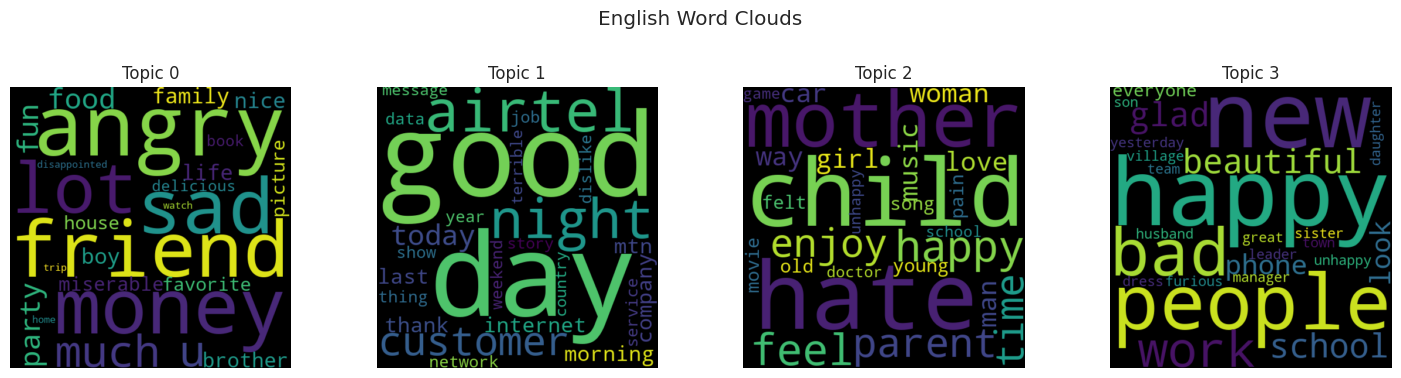

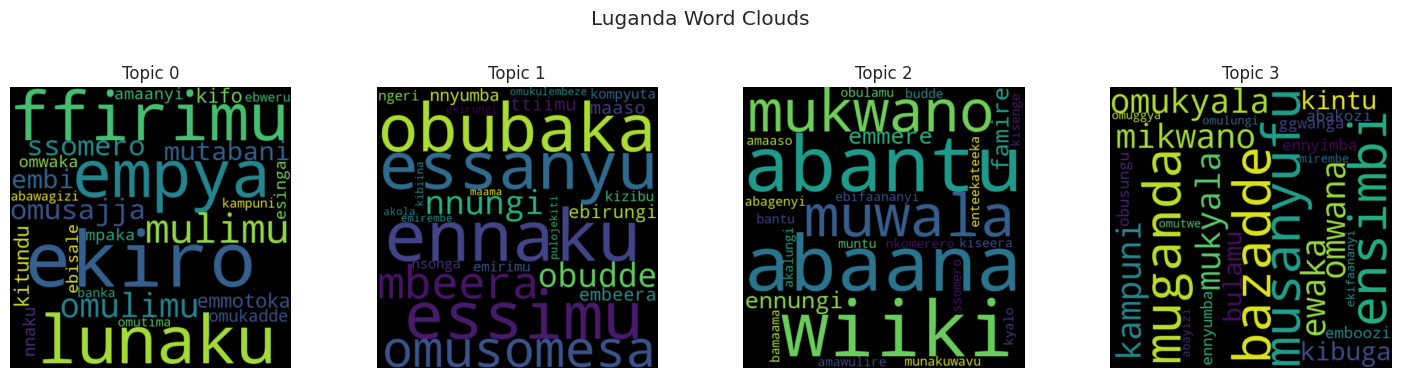

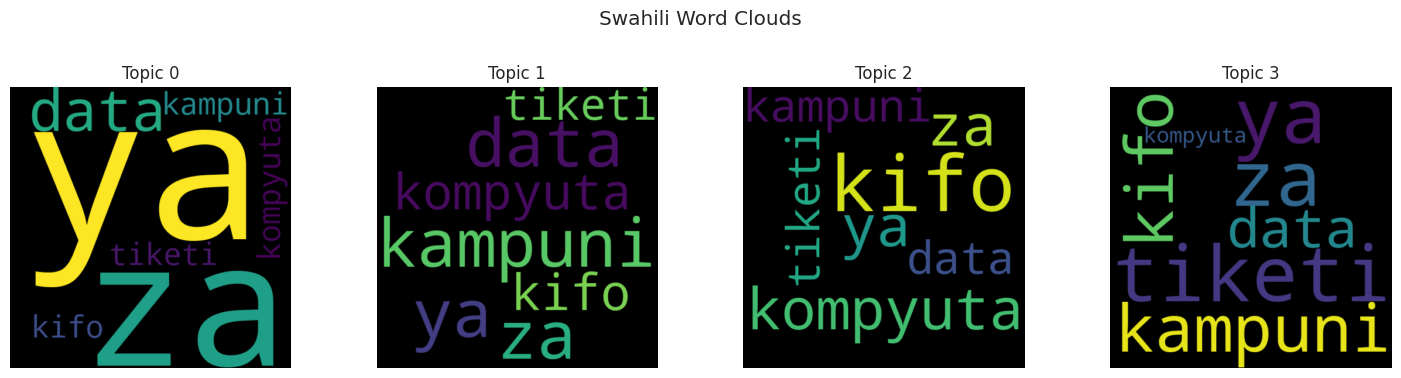

In [116]:
num_top_words = 25

print('Loaded English WordCloud')
wordcloud_top_words(english_major_topics, english_feature_names, num_top_words, 'English')

print('Loaded Luganda WordCloud')
wordcloud_top_words(luganda_major_topics, luganda_feature_names, num_top_words, 'Luganda')

print('Loaded Swahili WordCloud')
wordcloud_top_words(swahili_major_topics, swahili_feature_names, num_top_words, 'Swahili')

#### Storing the major topic

In [117]:
english_lda_corpus = english_lda_model[english_corpus]
luganda_lda_corpus = luganda_lda_model[luganda_corpus]
swahili_lda_corpus = swahili_lda_model[swahili_corpus]

#### Obtaining the main topic for each sentence

In [118]:
english_all_topics = english_lda_model.get_document_topics(english_corpus)
english_num_docs = len(english_all_topics)

english_all_topics_csr = gensim.matutils.corpus2csc(english_all_topics)
english_all_topics_numpy = english_all_topics_csr.T.toarray()

english_major_topic= [np.argmax(arr) for arr in english_all_topics_numpy]
english_df['major_lda_topic'] = english_major_topic

In [119]:
luganda_all_topics = luganda_lda_model.get_document_topics(luganda_corpus)
luganda_num_docs = len(luganda_all_topics)

luganda_all_topics_csr = gensim.matutils.corpus2csc(luganda_all_topics)
luganda_all_topics_numpy = luganda_all_topics_csr.T.toarray()

luganda_major_topic= [np.argmax(arr) for arr in luganda_all_topics_numpy]
reset_luganda_df['major_lda_topic'] = luganda_major_topic # We use the reset version

In [120]:
swahili_all_topics = swahili_lda_model.get_document_topics(swahili_corpus)
swahili_num_docs = len(swahili_all_topics)

swahili_all_topics_csr = gensim.matutils.corpus2csc(swahili_all_topics)
swahili_all_topics_numpy = swahili_all_topics_csr.T.toarray()

swahili_major_topic= [np.argmax(arr) for arr in swahili_all_topics_numpy]
reset_swahili_df['major_lda_topic'] = swahili_major_topic # We use the reset version

# Analysis

#### Analyse K-means Clustering against Topic Labeling

In [121]:
import seaborn as sns

def plot_bar_plot(df, language='English'):
    """
    Plots a bar plot showing the distribution of LDA topics in the given DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame containing the results of LDA topic modeling. The column 'major_lda_topic' should contain the topic assignments for each document.
        language (str, optional): The language of the data (default is 'English'). It is used for the plot title.

    Returns:
        None: This function generates and displays a bar plot showing the count of documents assigned to each LDA topic.

    Example:
        - plot_bar_plot(df, language='English')
    """
    sns.set(rc={'figure.figsize': (5, 3)})
    sns.set_style('darkgrid')
    
    # Plot countplot with major_lda_topic on x-axis
    ax = sns.countplot(x=df['major_lda_topic'])
    
    # Set labels and title
    ax.set_xlabel('LDA Topic')
    ax.set_ylabel('Value Counts')
    ax.set_title(f'{language}: LDA Value Counts Per Topic')
    plt.show()

## Analysis on English Data

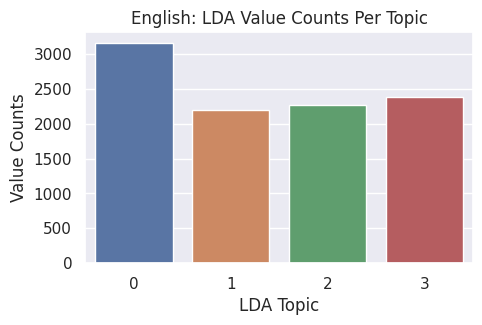

In [122]:
plot_bar_plot(english_df)

In [123]:
english_df.groupby(['klabels'])['major_lda_topic'].value_counts(ascending=False, normalize=True)

klabels  major_lda_topic
0        0                  0.443182
         1                  0.227273
         3                  0.193182
         2                  0.136364
1        1                  0.694915
                              ...   
98       2                  0.102041
99       0                  0.410256
         2                  0.230769
         3                  0.205128
         1                  0.153846
Name: proportion, Length: 399, dtype: float64

#### Deriving Conclusions- Looking at the data

In [124]:
english_cols = ['Sentiment', 'major_lda_topic']

english_cluster1= english_df.loc[(english_df.klabels==0)]
english_cluster2= english_df.loc[(english_df.klabels==1)]
english_cluster3= english_df.loc[(english_df.klabels==98)]
english_cluster4= english_df.loc[(english_df.klabels==99)]

In [125]:
def plot_sentiment_bar_plot(df, cluster, language='English'):
    """
    Plots a bar chart showing the sentiment distribution percentage for a specific cluster.

    This function calculates the percentage of each sentiment in the given cluster compared to the total sentiment distribution in the entire DataFrame and then plots a bar chart to visualise it.

    Args:
        df (pd.DataFrame): A DataFrame containing the sentiment data for the entire dataset. The 'Sentiment' column must include sentiment labels (e.g., 'positive', 'negative').
        cluster (pd.DataFrame): A DataFrame or Series representing a specific cluster or subset of the data, which includes a 'Sentiment' column for sentiment analysis.
        language (str, optional): The language of the data (default is 'English'). It is used for the plot title.

    Returns:
        None: This function generates and displays a bar plot showing the sentiment distribution percentage for a specific cluster.

    Example:
        - plot_sentiment_bar_plot(df, cluster, language='English')
    """
    # Get value counts of sentiments in the cluster
    cluster_sentiment_counts = cluster.Sentiment.value_counts()
    
    # Get total counts of each sentiment in the full dataframe
    total_sentiment_counts = df.Sentiment.value_counts()
    
    # Calculate percentage of sentiment in the cluster
    sentiment_percent = (cluster_sentiment_counts / total_sentiment_counts) * 100
    
    # Convert to DataFrame and plot
    sentiment_percent_df = pd.DataFrame(sentiment_percent)
    sentiment_percent_df.plot(kind='bar', figsize=(5, 3))
    
    plt.title(f'{language}: Sentiment Percentage per Cluster')
    plt.xlabel('Sentiment')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.show()

#### Cluster 0 analysis

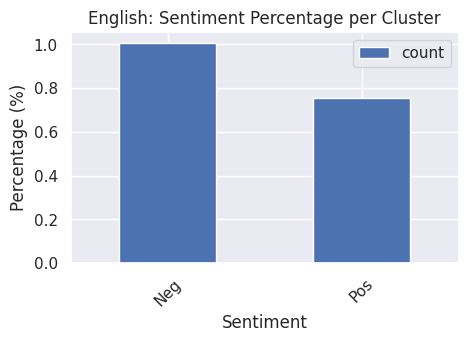

In [126]:
plot_sentiment_bar_plot(english_df, english_cluster1)

Visualising categorical features:


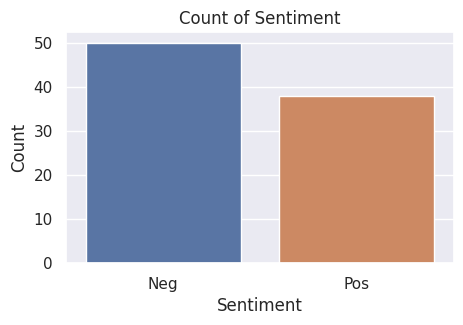

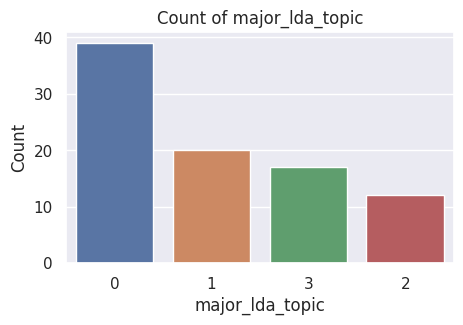

In [127]:
def visualise_categories(cat_cols, cluster):
    """
    Visualises the count distribution of categorical features in a given cluster.

    This function generates count plots for each categorical column specified in `cat_cols`, showing the distribution of values within each category for the provided `cluster`.

    Args:
        cat_cols (list): A list of column names that represent categorical features in the `cluster` DataFrame. Each column in this list should contain categorical data.
        cluster (pd.DataFrame): A DataFrame representing a specific cluster or subset of the data. It should contain the categorical columns specified in `cat_cols`.

    Returns:
        None: This function generates and displays count plots for each categorical column in `cat_cols`.

    Example:
        - visualise_categories(['Category1', 'Category2'], cluster)
    """
    print('Visualising categorical features:')
    for i, col in enumerate(cat_cols):
        plt.figure(i)
        chart = sns.countplot(data=cluster, x=col, order=cluster[col].value_counts().index)
        chart.set_xticklabels(chart.get_xticklabels())
        plt.title(f'Count of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.show()

visualise_categories(english_cols, english_cluster1)

#### Insights from the first cluster (cluster 0)

Several points can be drawn about the clustering and topic modeling performed for `cluster 0`:

- **Cluster Analysis:** Cluster 0 has a slight skew toward negative sentiment, with slighlty more negative sentences (50) compared to positive ones (≈ 38). This means that the sentences collected here are likely to be complaints, displeasure, or emotionally charged conversations.

- **Word Association:** The top words in this cluster (e.g., "faulty", "fault", "father", "fatal", "fat", "faster", "hate", "people", "much", "talk") may be indicative of personal relationships or emotional settings, as these terms frequently refer to personal encounters. However, the association to negative sentiment implies that the cluster may include discussions about disappointment or discontent in these circumstances.

- **Topic Correlation:** From the bar plot of major topics, we see that most of the words in this cluster appear to be from Topic 0, which includes phrases like "angry," "friend," "sad," "disappointed," and "miserable." This highlights the idea that Cluster 0 is concerned with emotionally negative or complex social interactions.

- **Negative Sentiment Prominence:** Given the prevalence of negative sentiment in this cluster, the terms could refer to conversations in which people express emotional distress, discontent with friends, or social events (e.g., parties or gatherings). The overlap with Topic 0's terms "angry," "sad," and "miserable" implies personal problems.

This demonstrates how topic modelling can work well with sentiment analysis, as certain clusters emphasise emotional content (positive or negative), assisting in the identification of patterns in text data.

#### Insights from the first cluster (cluster 0)

Several points can be drawn about the clustering and topic modelling performed for `cluster 0`:

- **Cluster Analysis:** Cluster 0 shows a tendency toward negative sentiment, with slightly higher negative sentiment counts (≈50) compared to positive (38). This implies that the cluster content may reflect complaints, frustrations, or negative emotions, suggesting a focus on conversations with a negative emotional charge.

- **Word Association:** The top words in Cluster 0, including "faulty," "fault," "hate," and "fatal," suggest issues or dissatisfaction, potentially in personal or social contexts. The presence of words like "father" and "people" implies an emotional aspect, possibly linked to relational or social complaints.

- **Topic Correlation:** Most words in Cluster 0 align with Topic 0, which includes words like "angry," "sad," "miserable," and "disappointed." This correlation strengthens the impression that this cluster centres around negative or complex emotional expressions, particularly within social or familial settings.

- **Negative Sentiment Prominence:** The overlap between the negative sentiment in Cluster 0 and Topic 0’s focus on distressful emotions suggests that this cluster represents conversations where individuals express frustration or disappointment, particularly in social or family contexts.

This demonstrates how topic modelling can work well with sentiment analysis, as certain clusters emphasise emotional content (positive or negative), assisting in the identification of patterns in text data.

## Analysis on Luganda Data

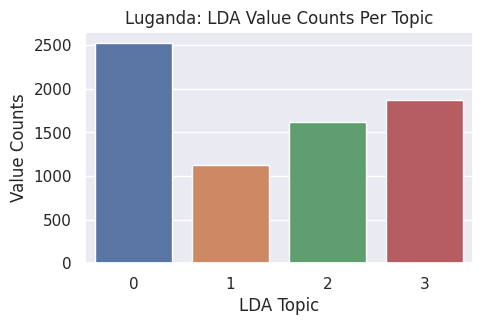

In [128]:
plot_bar_plot(reset_luganda_df, 'Luganda')

In [129]:
reset_luganda_df.groupby(['klabels'])['major_lda_topic'].value_counts(ascending=False, normalize=True)

klabels  major_lda_topic
0        0                  0.494382
         3                  0.247191
         2                  0.146067
         1                  0.112360
1        0                  0.361111
                              ...   
58       1                  0.017544
59       0                  0.397436
         3                  0.250000
         2                  0.185897
         1                  0.166667
Name: proportion, Length: 239, dtype: float64

#### Deriving Conclusions- Looking at the data

In [130]:
luganda_cols = ['Sentiment', 'major_lda_topic']

luganda_cluster1= reset_luganda_df.loc[(reset_luganda_df.klabels==0)]
luganda_cluster2= reset_luganda_df.loc[(reset_luganda_df.klabels==1)]
luganda_cluster3= reset_luganda_df.loc[(reset_luganda_df.klabels==58)]
luganda_cluster4= reset_luganda_df.loc[(reset_luganda_df.klabels==59)]

#### Cluster 0 Analysis

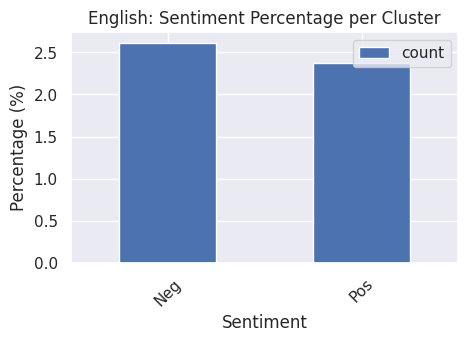

In [131]:
plot_sentiment_bar_plot(reset_luganda_df, luganda_cluster1)

Visualising categorical features:


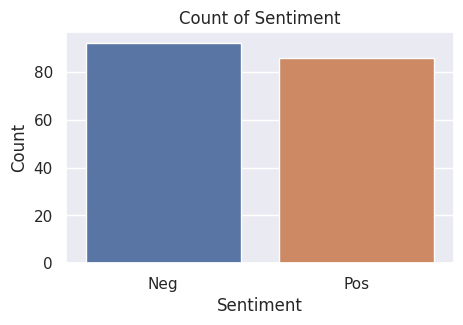

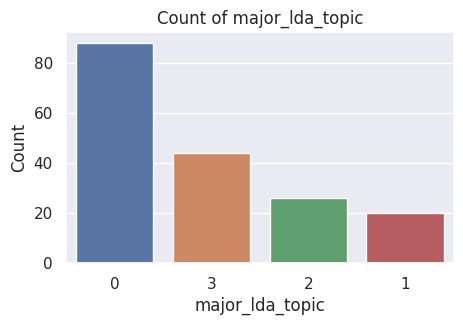

In [132]:
visualise_categories(luganda_cols, luganda_cluster1)

#### Insights from the first cluster (cluster 0)

Several points can be drawn about the clustering and topic modeling performed for `cluster 0`:

Cluster 0 top words: eziyingizibwa,eziyigiriza,eziyakaayakana,eziwoggana,eziwera,ezitwala,ezzaamu,omwana,omulungi,mmwagala

English translations: inclusive,educational,bright,whispering,numerous,carrying,refreshing,baby,beautiful,love

Gemini's translations:
- eziyingizibwa: generally it refers to things that are "imported" or "brought in."
- eziyigiriza: this means "educational" or "instructive."
- eziyakaayakana: it can mean "flashy," "showy," or "attention-seeking."
- eziwoggana: it means "conflicting" or "arguing."
- eziwera: it refers to "numerous" or "many."
- ezitwala: it means "carrying" or "transporting."
- ezzaamu: it refers to "refreshing" or "giving strength" or "energy".
- omwana: this word means "child," or "baby."
- omulungi: it means "good" or "beautiful."
- mmwagala: refers to "love" or "I love you."

Translations were given by [imtranslator](https://imtranslator.net/translation/luganda/to-english/translation/). The context of these possible translations were checked using [English-Luganda-parallel-corpus](https://raw.githubusercontent.com/kimrichies/English-Luganda-Parallel-corpus/refs/heads/main/FinalMergedDataset5.txt). Additionally, the Luganda words were given to Google's Gemini to provide the context (in English) of those Luganda words. Clearly some translations may be slightly inaccurate, however the focus is on the context to get insights from the clusters and topics.

- **Cluster Analysis:** Cluster 0 exhibits a nearly balanced sentiment distribution, with a slight leaning toward negative sentiment (90 negative mentions vs. 85 positive). This balance suggests a subtle mix of perspectives, where discussions may touch on both challenges and uplifting moments in personal life or education.

- **Word Association:** Top words such as "omwana" (child or baby), "eziyigiriza" (educational), and "omulungi" (beautiful) imply themes around family, education, and admiration. These words indicate that this cluster likely involves social and family settings, with sentiments that may range from affection and joy to concern or worry.

- **Topic Correlation:** The words in Cluster 0 align mainly with Topic 0, which includes terms like "ssomero" (school), "mutabani" (son), and "omusajja" (man), further suggesting a focus on family dynamics and educational contexts. This points toward discussions involving children, school-related issues, or social interactions among family members.

- **Negative Sentiment Prominence:** The slight presence of negative sentiment, along with words such as "embi" (bad) and "nnaku" (sadness), indicates a potential focus on the struggles or challenges within family life, educational contexts, or social environments. However, the presence of terms like "omulungi" and "mmwagala" (love) highlights moments of positivity and emotional support within these contexts.


## Analysis on Swahili Data

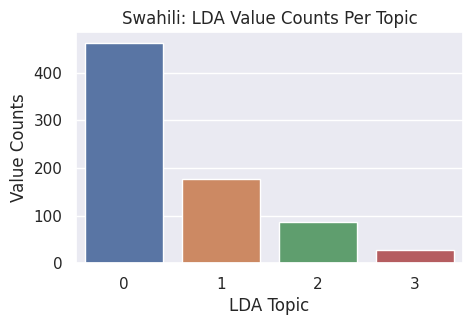

In [133]:
plot_bar_plot(reset_swahili_df, 'Swahili')

In [134]:
reset_swahili_df.groupby(['klabels'])['major_lda_topic'].value_counts(ascending=False, normalize=True)

klabels  major_lda_topic
0        1                  0.666667
         2                  0.148148
         0                  0.111111
         3                  0.074074
1        0                  1.000000
                              ...   
77       0                  0.487179
78       0                  0.666667
         1                  0.333333
79       0                  0.700000
         2                  0.300000
Name: proportion, Length: 152, dtype: float64

#### Deriving Conclusions- Looking at the data

In [135]:
swahili_cols = ['Sentiment', 'major_lda_topic']

swahili_cluster1= reset_swahili_df.loc[(reset_swahili_df.klabels==0)]
swahili_cluster2= reset_swahili_df.loc[(reset_swahili_df.klabels==1)]
swahili_cluster3= reset_swahili_df.loc[(reset_swahili_df.klabels==77)]
swahili_cluster4= reset_swahili_df.loc[(reset_swahili_df.klabels==79)]

#### Cluster 0 Analysis

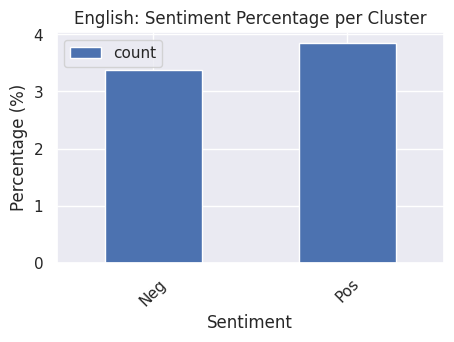

In [136]:
plot_sentiment_bar_plot(reset_swahili_df, swahili_cluster1)

Visualising categorical features:


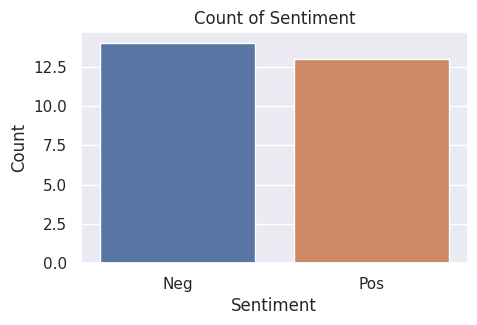

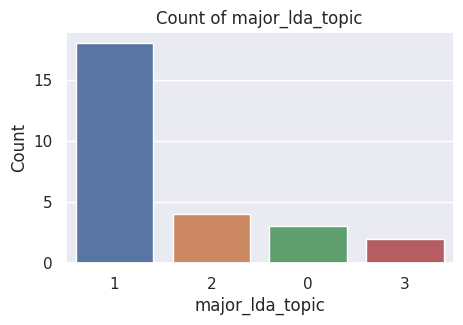

In [137]:
visualise_categories(swahili_cols, swahili_cluster1)

#### Insights from the first cluster (cluster 0)

Several points can be drawn about the clustering and topic modeling performed for `cluster 0`:

Cluster 0 top words: kuendana,kudundika,kudumu,kudumisha,kudukuliwa,kuendesha,ana,maumivu,makali,kichwa

English translations: match, hang, last, maintain, hacked, drive, has, pain, severe, headache

Gemini's translations:
- kuendana: to match, to fit, to go together
- kudundika: to knock, to rap, to tap
- kudumu: to last, to endure
- kudumisha: to maintain, to preserve
- kudukuliwa: to be beaten, to be thrashed (this can also have a more figurative meaning, like being overwhelmed or defeated)
- kuendesha: to drive, to operate, to manage
- ana: children (plural)
- maumivu: pain
- makali: sharp, strong, severe
- kichwa: head

Translations were given by [imtranslator](https://imtranslator.net/translation/luganda/to-english/translation/). The context of these possible translations were checked using [Translators Without Borders](https://gamayun.translatorswb.org/download/gamayun-5k-english-swahili/). Additionally, the Swahili words were given to Google's Gemini to provide the context (in English) of those Swahili words. Clearly some translations may be slightly inaccurate, however the focus is on the context to get insights from the clusters and topics.

- **Cluster Analysis:** Cluster 0 leans slightly toward negative sentiment with 15 negative mentions versus 13 positive, suggesting it captures a subtle perspective that may include both challenges and strength in personal or physical circumstances, with themes such as "pain" (maumivu) and "severe" (makali) appearing.

- **Word Association:**  The top words, such as "kuendana" (to match) and "kudumisha" (to maintain), suggest themes around resilience, ongoing efforts, and the physical or emotional toll of certain experiences, implying this cluster may capture both sustaining efforts and struggles. Words such as "maumivu" (pain) and "kichwa" (head) could indicate themes around health or difficult life circumstances.

- **Topic Correlation:** Most words align with Topic 0, which includes common connectors like "ya" (of) and "za" (from), indicating the broader applicability and connection of this cluster to everyday discussions in Swahili, potentially covering daily events, health, or well-being. Terms such as "kampuni" (company) and "data" suggest an additional, albeit subtle, overlap with technical or formal topics.

- **Negative Sentiment Prominence:** Given the words associated with pain or hardship, along with terms indicating resilience and continuity, this cluster might focus on health or life challenges within a social or work context. Negative sentiment likely emerges from health issues or struggles, while positive sentiment stems from themes of endurance and perseverance.



In [ ]:
!pip freeze > requirements.txt